## Annotate MT variants using mseqdr tool

Reference and curl API instructions: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5992054/   
Database: https://mseqdr.org/portal.php?dbsource=genomic&name=m.16127A%3EG&x=0&y=0

In [1]:
# The input vcf path
vcf_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/variants.vcf"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants"

mt_fasta = "/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta" # "example_data/hg19_chr22.fa"
isRawVCF = False

In [2]:
from Bio import SeqIO
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
anno_json_f = join(outdir, "vars_anno.json")
varType_out_f = join(outdir, "varsType.tsv")
anno_out_f = join(outdir, "anno_variants.tsv")
fig_anno_vars_f = join(outdir, "vars_anno.pdf")

In [4]:
## Create proper formatted vcf file

if isRawVCF:
    print("Processing VCF")
    for record in SeqIO.parse(mt_fasta, "fasta"):
        mt_seq = record.seq
    mt_seq

    vcf_path = raw_vcf.replace(".vcf", ".fmt.vcf")

    vcf = pd.read_csv(raw_vcf, sep='\t')
    vcf["QUAL"] = "."
    vcf["FILTER"] = "."
    vcf["INFO"] = "."
    vcf["ID"] = "."
    vcf["REF"] = vcf["REF"].apply(lambda x: x[-1])
    vcf = vcf[["#CHROM" ,"POS","ID","REF","ALT","QUAL","FILTER","INFO"]]
    vcf

    header = "##fileformat=VCFv4.0"
    header = header + "\n" + f"##reference=file:/{mt_fasta}"
    #vcf.to_csv(vcf_path, sep='\t', index=False)
    with open(vcf_path, 'a') as file:
        file.write(header)
        vcf.to_csv(vcf_path, sep='\t', index=False)

else:
    vcf_path = vcf_f

## Get transition-transversion

In [5]:
import src.utils.variant_utils as vu

In [6]:
variants = pd.read_csv(vcf_path, skiprows=2,sep='\t', index_col=None)
variants

#variants["REF"] = [x[:-1] for x in variants["REF"]]

def type_of_variants(variants):
    # Get types of mutations
    def var_type(x):
        nts = set(x[["REF", "ALT"]])
        if "N" in nts:
            return "Undefined"
        if nts == {"A", "G"} or nts == {"T", "C"}:
            return "Transition"
        return "Transversion"
    variants["variant type"] = variants.apply(var_type, axis=1)
    variants["variant change"] = variants["REF"]+">"+variants["ALT"]
    return variants

In [7]:
variants = type_of_variants(variants=variants).set_index("ID")
variants.to_csv(varType_out_f, sep="\t")
#vu.type_of_variants(variants=variants, to_preproc=False)

## Run annotation

In [8]:
cmd = f"curl -s -X POST https://mseqdr.org/mtannotapi.php?format=vcf --data-binary @{vcf_path} -o {anno_json_f}"
print(cmd)

curl -s -X POST https://mseqdr.org/mtannotapi.php?format=vcf --data-binary @/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/variants.vcf -o /data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/vars_anno.json


In [9]:
!{cmd}

# Check results

In [10]:
import json
var_ann = json.load(open(anno_json_f))
var_ann

{'mseqdr': [{'Input': 'm.58C>.',
   'HGVS_g': None,
   'AF_M1': '-',
   'M1_cnt': '-',
   'AF_mitomap': '-',
   'Mitomap_cnt': '-',
   'Mitomap_Pubmed': 'OMITTED',
   'Mitomap_Allele': '-',
   'Mitomap_Disease': '-',
   'Heteroplasmy': '-',
   'Mitomap_status': '-',
   'HmtDB': '-',
   'NT_variability': '-',
   'AF_A_GeneDX': '0.0045850000000000005',
   'AF_C_GeneDX': '0.0004',
   'AF_G_GeneDX': '0',
   'AF_T_GeneDX': '0.995',
   'Total_GeneDX': '5453',
   'AF_GEMapp': '-',
   'Genotype_GEMAPP': '-',
   'Homoplasmy': '-',
   'AA_variability': '-',
   'HmtDB_disease': '-'},
  {'Input': 'm.64T>.',
   'HGVS_g': None,
   'AF_M1': '-',
   'M1_cnt': '-',
   'AF_mitomap': '-',
   'Mitomap_cnt': '-',
   'Mitomap_Pubmed': 'OMITTED',
   'Mitomap_Allele': '-',
   'Mitomap_Disease': '-',
   'Heteroplasmy': '-',
   'Mitomap_status': '-',
   'HmtDB': '-',
   'NT_variability': '-',
   'AF_A_GeneDX': '0',
   'AF_C_GeneDX': '0.9776',
   'AF_G_GeneDX': '0',
   'AF_T_GeneDX': '0.0222',
   'Total_GeneDX':

In [11]:
var_ann.keys()

dict_keys(['mseqdr', 'general', 'population', 'mutalyzer', 'ensembl_vep_grch37', 'dbnsfp', 'hgmd'])

In [12]:
population = pd.DataFrame(var_ann["population"]).set_index("Input")
population
population = pd.DataFrame(var_ann["population"]).set_index("Input")
print(population.shape)
population[population=="-"] = np.nan
population = population.dropna(how="all", axis=1)
print(population.shape)


(231, 20)
(231, 1)


In [13]:
population = pd.DataFrame(var_ann["population"]).set_index("Input")
print(population.shape)
population[population=="-"] = np.nan
population = population.dropna(how="all", axis=1)
print(population.shape)

dbnsfp = pd.DataFrame(var_ann["dbnsfp"]).set_index("Input")
print(dbnsfp.shape)
dbnsfp[dbnsfp=="-"] = np.nan
dbnsfp = dbnsfp.dropna(how="all", axis=1)
print(dbnsfp.shape)

#dbnsfp["Ensembl_transcriptid"].unique()

mseqdr = pd.DataFrame(var_ann["mseqdr"]).set_index("Input")
print(mseqdr.shape)
mseqdr[mseqdr=="-"] = np.nan
mseqdr = mseqdr.dropna(how="all", axis=1)
print(mseqdr.shape)


general= pd.DataFrame(var_ann["general"]).set_index("Input")
general
{x:general[x].unique() for x in general.columns}
print(general.shape)
general[general=="-"] = np.nan
general = general.dropna(how="all", axis=1)
print(general.shape)

(231, 20)
(231, 1)
(231, 63)
(231, 0)
(231, 22)
(231, 6)
(231, 24)
(231, 12)


In [14]:
var_anno_df = pd.concat([general, population, dbnsfp, mseqdr], axis=1, verify_integrity=True)
var_anno_df

Chr    Pos    GERP     LSDB_ID    LSDB_DBID LSDB_hgvs_g  \
Input                                                                
m.58C>.      M     58       0         NaN          NaN         NaN   
m.64T>.      M     64       0  0000004740  chrM_001238     m.64C>T   
m.146C>.     M    146       0  0000004070  chrM_001244    m.146T>C   
m.150T>.     M    150       0  0000004110  chrM_001245    m.150C>T   
m.152C>.     M    152       0  0000004130  chrM_001246    m.152T>C   
...         ..    ...     ...         ...          ...         ...   
m.16311C>.   M  16311    -6.7  0000004258  chrM_000347  m.16311T>C   
m.16311G>.   M  16311    -6.7  0000004258  chrM_000347  m.16311T>C   
m.16387G>.   M  16387    -4.6         NaN          NaN         NaN   
m.16519G>.   M  16519  0.0676  0000004280  chrM_000584  m.16519T>C   
m.16519A>.   M  16519  0.0676  0000004280  chrM_000584  m.16519T>C   

           ClinVar_RCVaccession ClinVar_Name ClinVar_ClinicalSignificance  \
Input                                                                       
m.58C>.                     NaN          NaN                          NaN   
m.64T>.                     NaN          NaN                          NaN   
m.146C>.                    NaN          NaN                          NaN   
m.150T>.                    NaN          NaN                          NaN   
m.152C>.                    NaN          NaN                          NaN   
...                         ...          ...                          ...   
m.16311C>.                  NaN          NaN                          NaN   
m.16311G>.                  NaN          NaN                          NaN   
m.16387G>.                  NaN          NaN                          NaN   
m.16519G>.                  NaN          NaN                          NaN   
m.16519A>.                  NaN          NaN                          NaN   

           ClinVar_PhenotypeIDs ClinVar_Disease ClinVar_OtherIDs  \
Input                                                              
m.58C>.                     NaN             NaN              NaN   
m.64T>.                     NaN             NaN              NaN   
m.146C>.                    NaN             NaN              NaN   
m.150T>.                    NaN             NaN              NaN   
m.152C>.                    NaN             NaN              NaN   
...                         ...             ...              ...   
m.16311C>.                  NaN             NaN              NaN   
m.16311G>.                  NaN             NaN              NaN   
m.16387G>.                  NaN             NaN              NaN   
m.16519G>.                  NaN             NaN              NaN   
m.16519A>.                  NaN             NaN              NaN   

                       CL Mitomap_Pubmed             AF_A_GeneDX AF_C_GeneDX  \
Input                                                                          
m.58C>.     0/1055:0.0000        OMITTED   0.0045850000000000005      0.0004   
m.64T>.     0/1055:0.0000        OMITTED                       0      0.9776   
m.146C>.    0/1055:0.0000        OMITTED  0.00036700000000000003      0.1649   
m.150T>.    0/1055:0.0000        OMITTED                       0      0.8702   
m.152C>.    0/1055:0.0000        OMITTED                       0       0.272   
...                   ...            ...                     ...         ...   
m.16311C>.  0/1055:0.0000        OMITTED                       0      0.2014   
m.16311G>.  0/1055:0.0000        OMITTED                       0      0.2014   
m.16387G>.  0/1055:0.0000        OMITTED                     NaN         NaN   
m.16519G>.  0/1055:0.0000        OMITTED                       0       0.623   
m.16519A>.  0/1055:0.0000        OMITTED                       0       0.623   

           AF_G_GeneDX         AF_T_GeneDX Total_GeneDX  
Input                                                    
m.58C>.              0               0.995         5453 

In [15]:
pos = var_anno_df.groupby("Pos").size()>1
var_anno_df.loc[var_anno_df["Pos"].isin(pos[pos].index)].sort_values("Pos")

Chr    Pos   GERP     LSDB_ID    LSDB_DBID LSDB_hgvs_g  \
Input                                                               
m.1169T>.    M   1169   3.69         NaN          NaN         NaN   
m.1169A>.    M   1169   3.69         NaN          NaN         NaN   
m.11719A>.   M  11719  -9.24  0000003778  chrM_001346  m.11719G>A   
m.11719T>.   M  11719  -9.24  0000003778  chrM_001346  m.11719G>A   
m.1201C>.    M   1201    4.5         NaN          NaN         NaN   
...         ..    ...    ...         ...          ...         ...   
m.8926A>.    M   8926    4.9         NaN          NaN         NaN   
m.9087A>.    M   9087   -9.8         NaN          NaN         NaN   
m.9087T>.    M   9087   -9.8         NaN          NaN         NaN   
m.9750A>.    M   9750   3.08         NaN          NaN         NaN   
m.9750G>.    M   9750   3.08         NaN          NaN         NaN   

           ClinVar_RCVaccession ClinVar_Name ClinVar_ClinicalSignificance  \
Input                                                                       
m.1169T>.                   NaN          NaN                          NaN   
m.1169A>.                   NaN          NaN                          NaN   
m.11719A>.                  NaN          NaN                          NaN   
m.11719T>.                  NaN          NaN                          NaN   
m.1201C>.                   NaN          NaN                          NaN   
...                         ...          ...                          ...   
m.8926A>.                   NaN          NaN                          NaN   
m.9087A>.                   NaN          NaN                          NaN   
m.9087T>.                   NaN          NaN                          NaN   
m.9750A>.                   NaN          NaN                          NaN   
m.9750G>.                   NaN          NaN                          NaN   

           ClinVar_PhenotypeIDs ClinVar_Disease ClinVar_OtherIDs  \
Input                                                              
m.1169T>.                   NaN             NaN              NaN   
m.1169A>.                   NaN             NaN              NaN   
m.11719A>.                  NaN             NaN              NaN   
m.11719T>.                  NaN             NaN              NaN   
m.1201C>.                   NaN             NaN              NaN   
...                         ...             ...              ...   
m.8926A>.                   NaN             NaN              NaN   
m.9087A>.                   NaN             NaN              NaN   
m.9087T>.                   NaN             NaN              NaN   
m.9750A>.                   NaN             NaN              NaN   
m.9750G>.                   NaN             NaN              NaN   

                       CL Mitomap_Pubmed         AF_A_GeneDX AF_C_GeneDX  \
Input                                                                      
m.1169T>.   0/1055:0.0000        OMITTED                 NaN         NaN   
m.1169A>.   0/1055:0.0000        OMITTED                 NaN         NaN   
m.11719A>.  0/1055:0.0000        OMITTED  0.8321080000000001           0   
m.11719T>.  0/1055:0.0000        OMITTED  0.8321080000000001           0   
m.1201C>.   0/1055:0.0000        OMITTED                 NaN         NaN   
...                   ...            ...                 ...         ...   
m.8926A>.   0/1055:0.0000        OMITTED                 NaN         NaN   
m.9087A>.   0/1055:0.0000        OMITTED                 NaN         NaN   
m.9087T>.   0/1055:0.0000        OMITTED                 NaN         NaN   
m.9750A>.   0/1055:0.0000        OMITTED                   0      0.0008   
m.9750G>.   0/1055:0.0000        OMITTED                   0      0.0008   

           AF_G_GeneDX AF_T_GeneDX Total_GeneDX  
Input                                            
m.1169T>.          NaN         NaN          NaN  
m.1169A>.          NaN         NaN          NaN  
m.11719A>.    0.167892           0   

In [16]:
# %matplotlib inline
# g = sns.catplot(data=var_anno_df.reset_index().melt(id_vars="ID", var_name="anno"),
#                 col="anno", kind="count", y="value", row="ID")
# #var_anno_df.reset_index().melt(id_vars="ID", var_name="anno")
# plt.savefig(fig_anno_vars_f, dpi=500, bbox_inches='tight', pad_inches=0.5)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  if sys.path[0] == "":
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  if sys.path[0] == "":


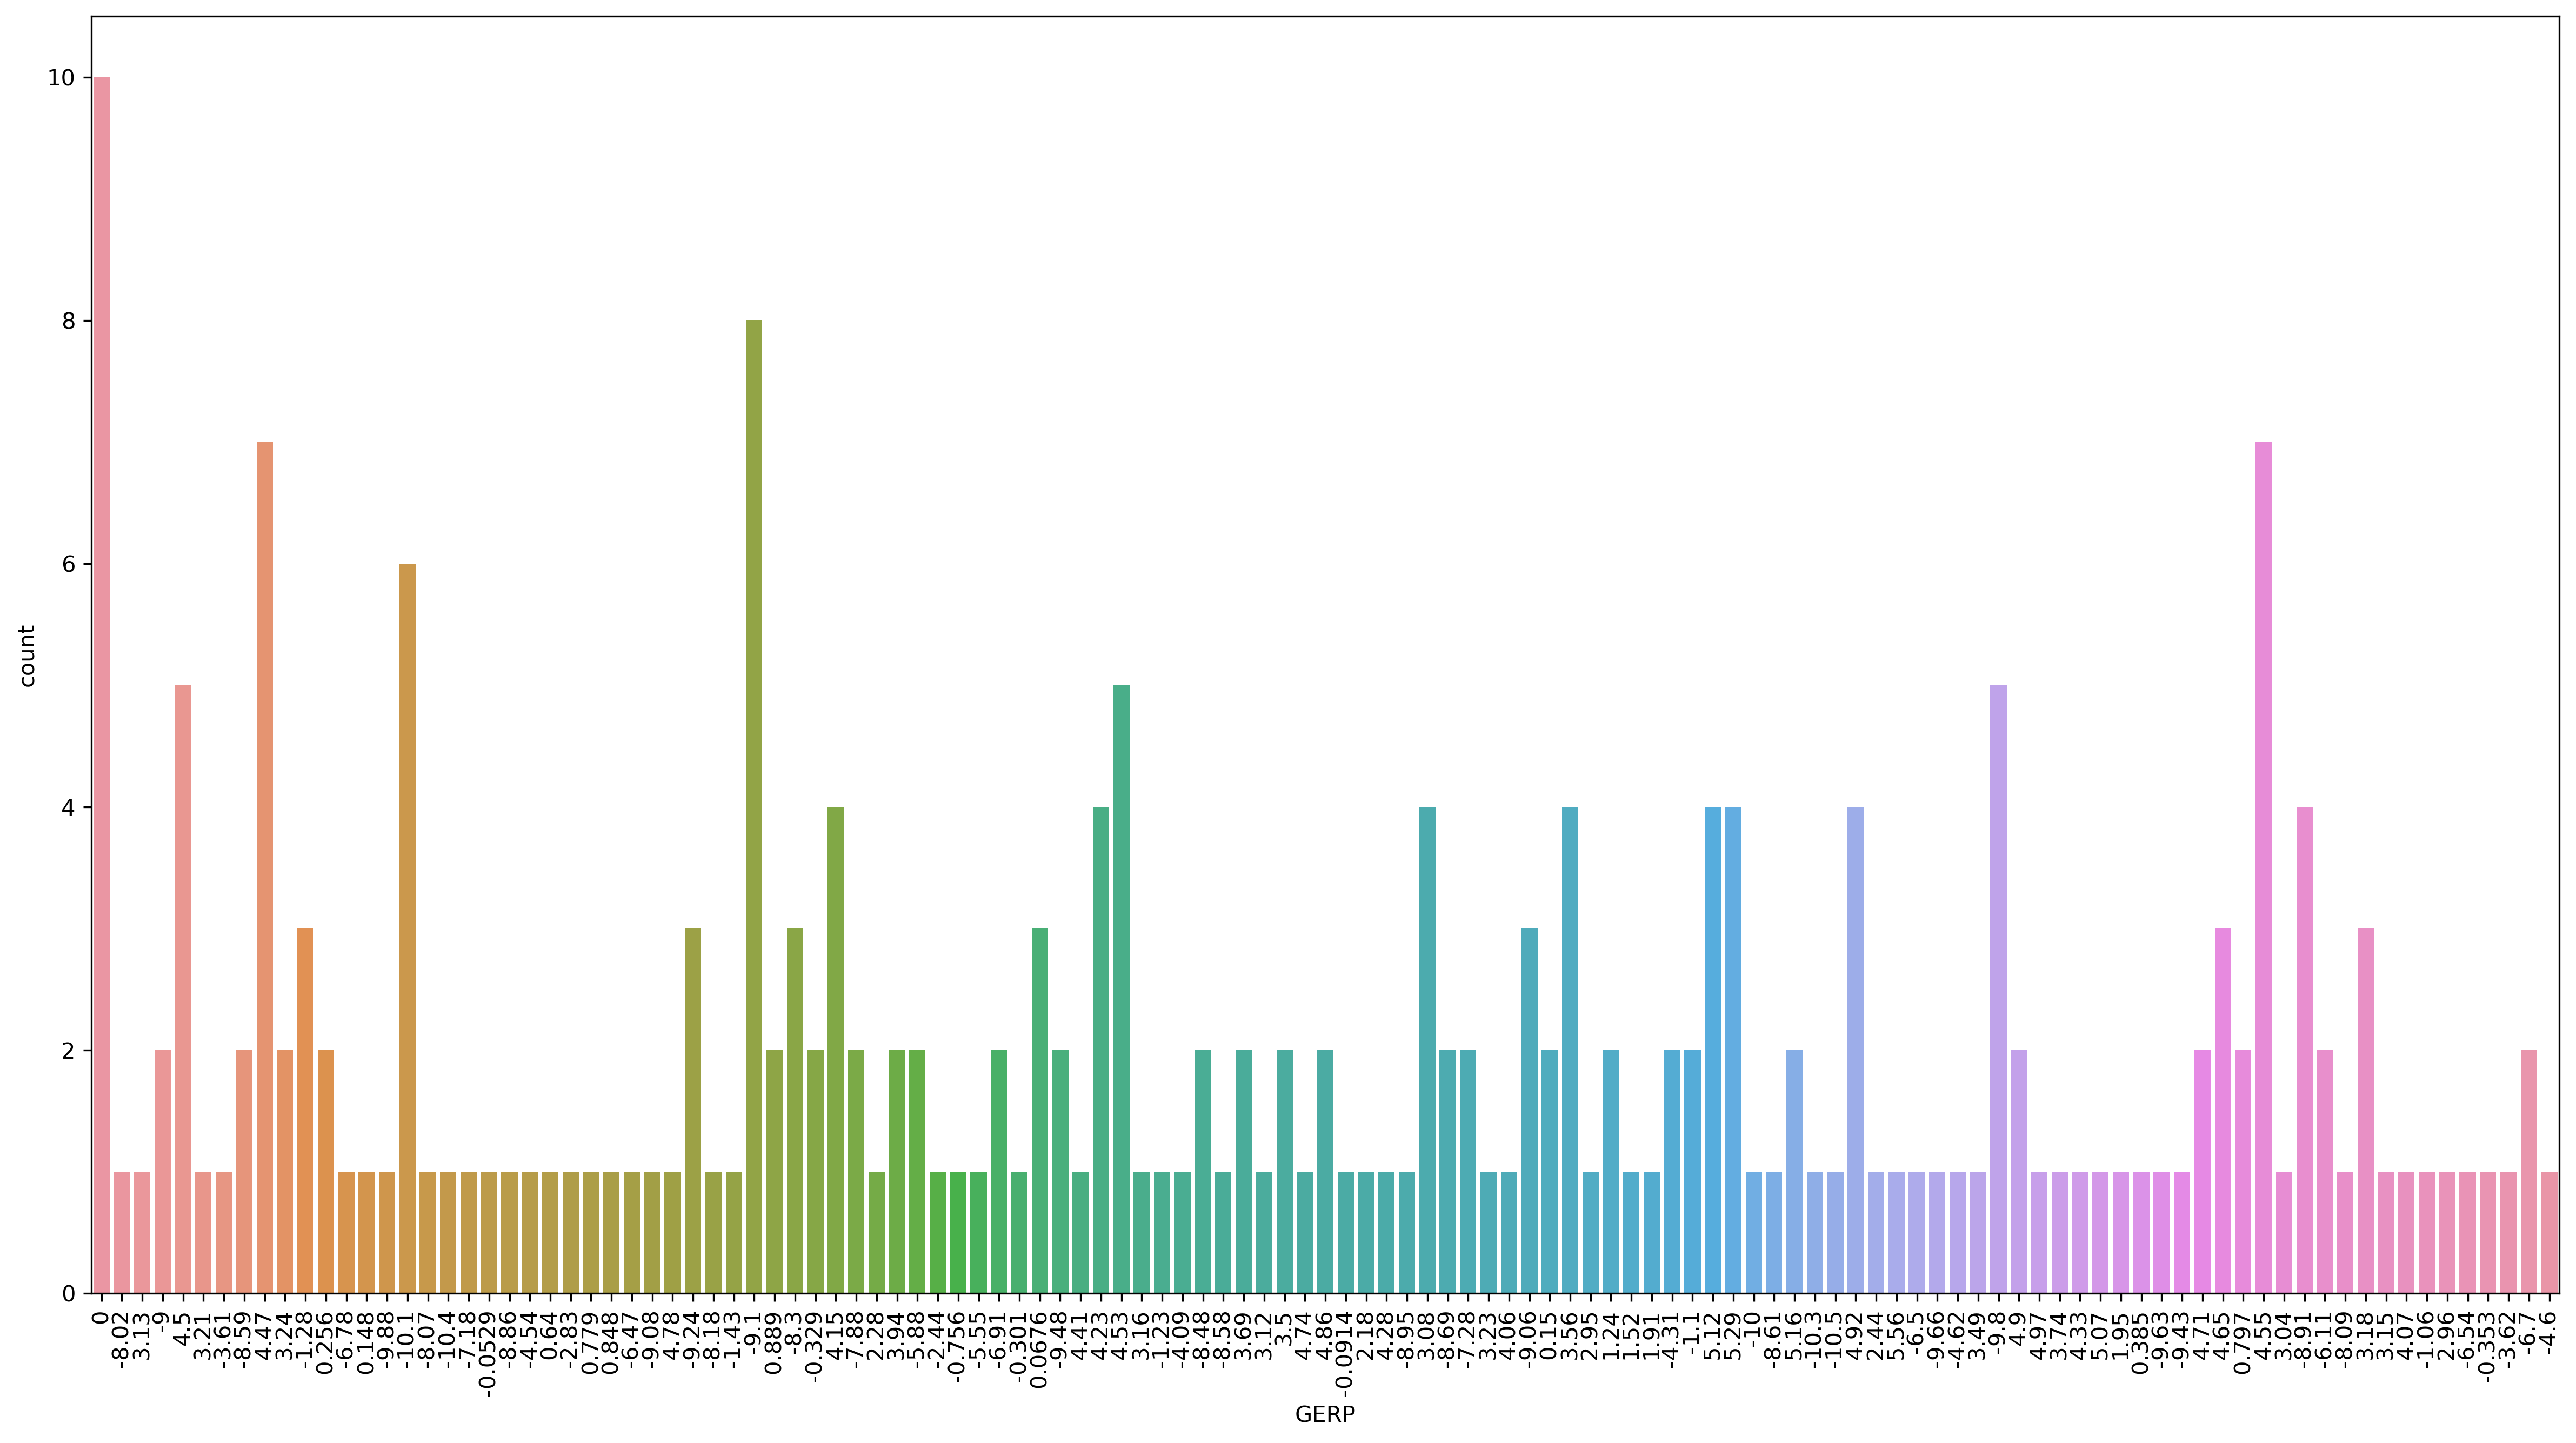

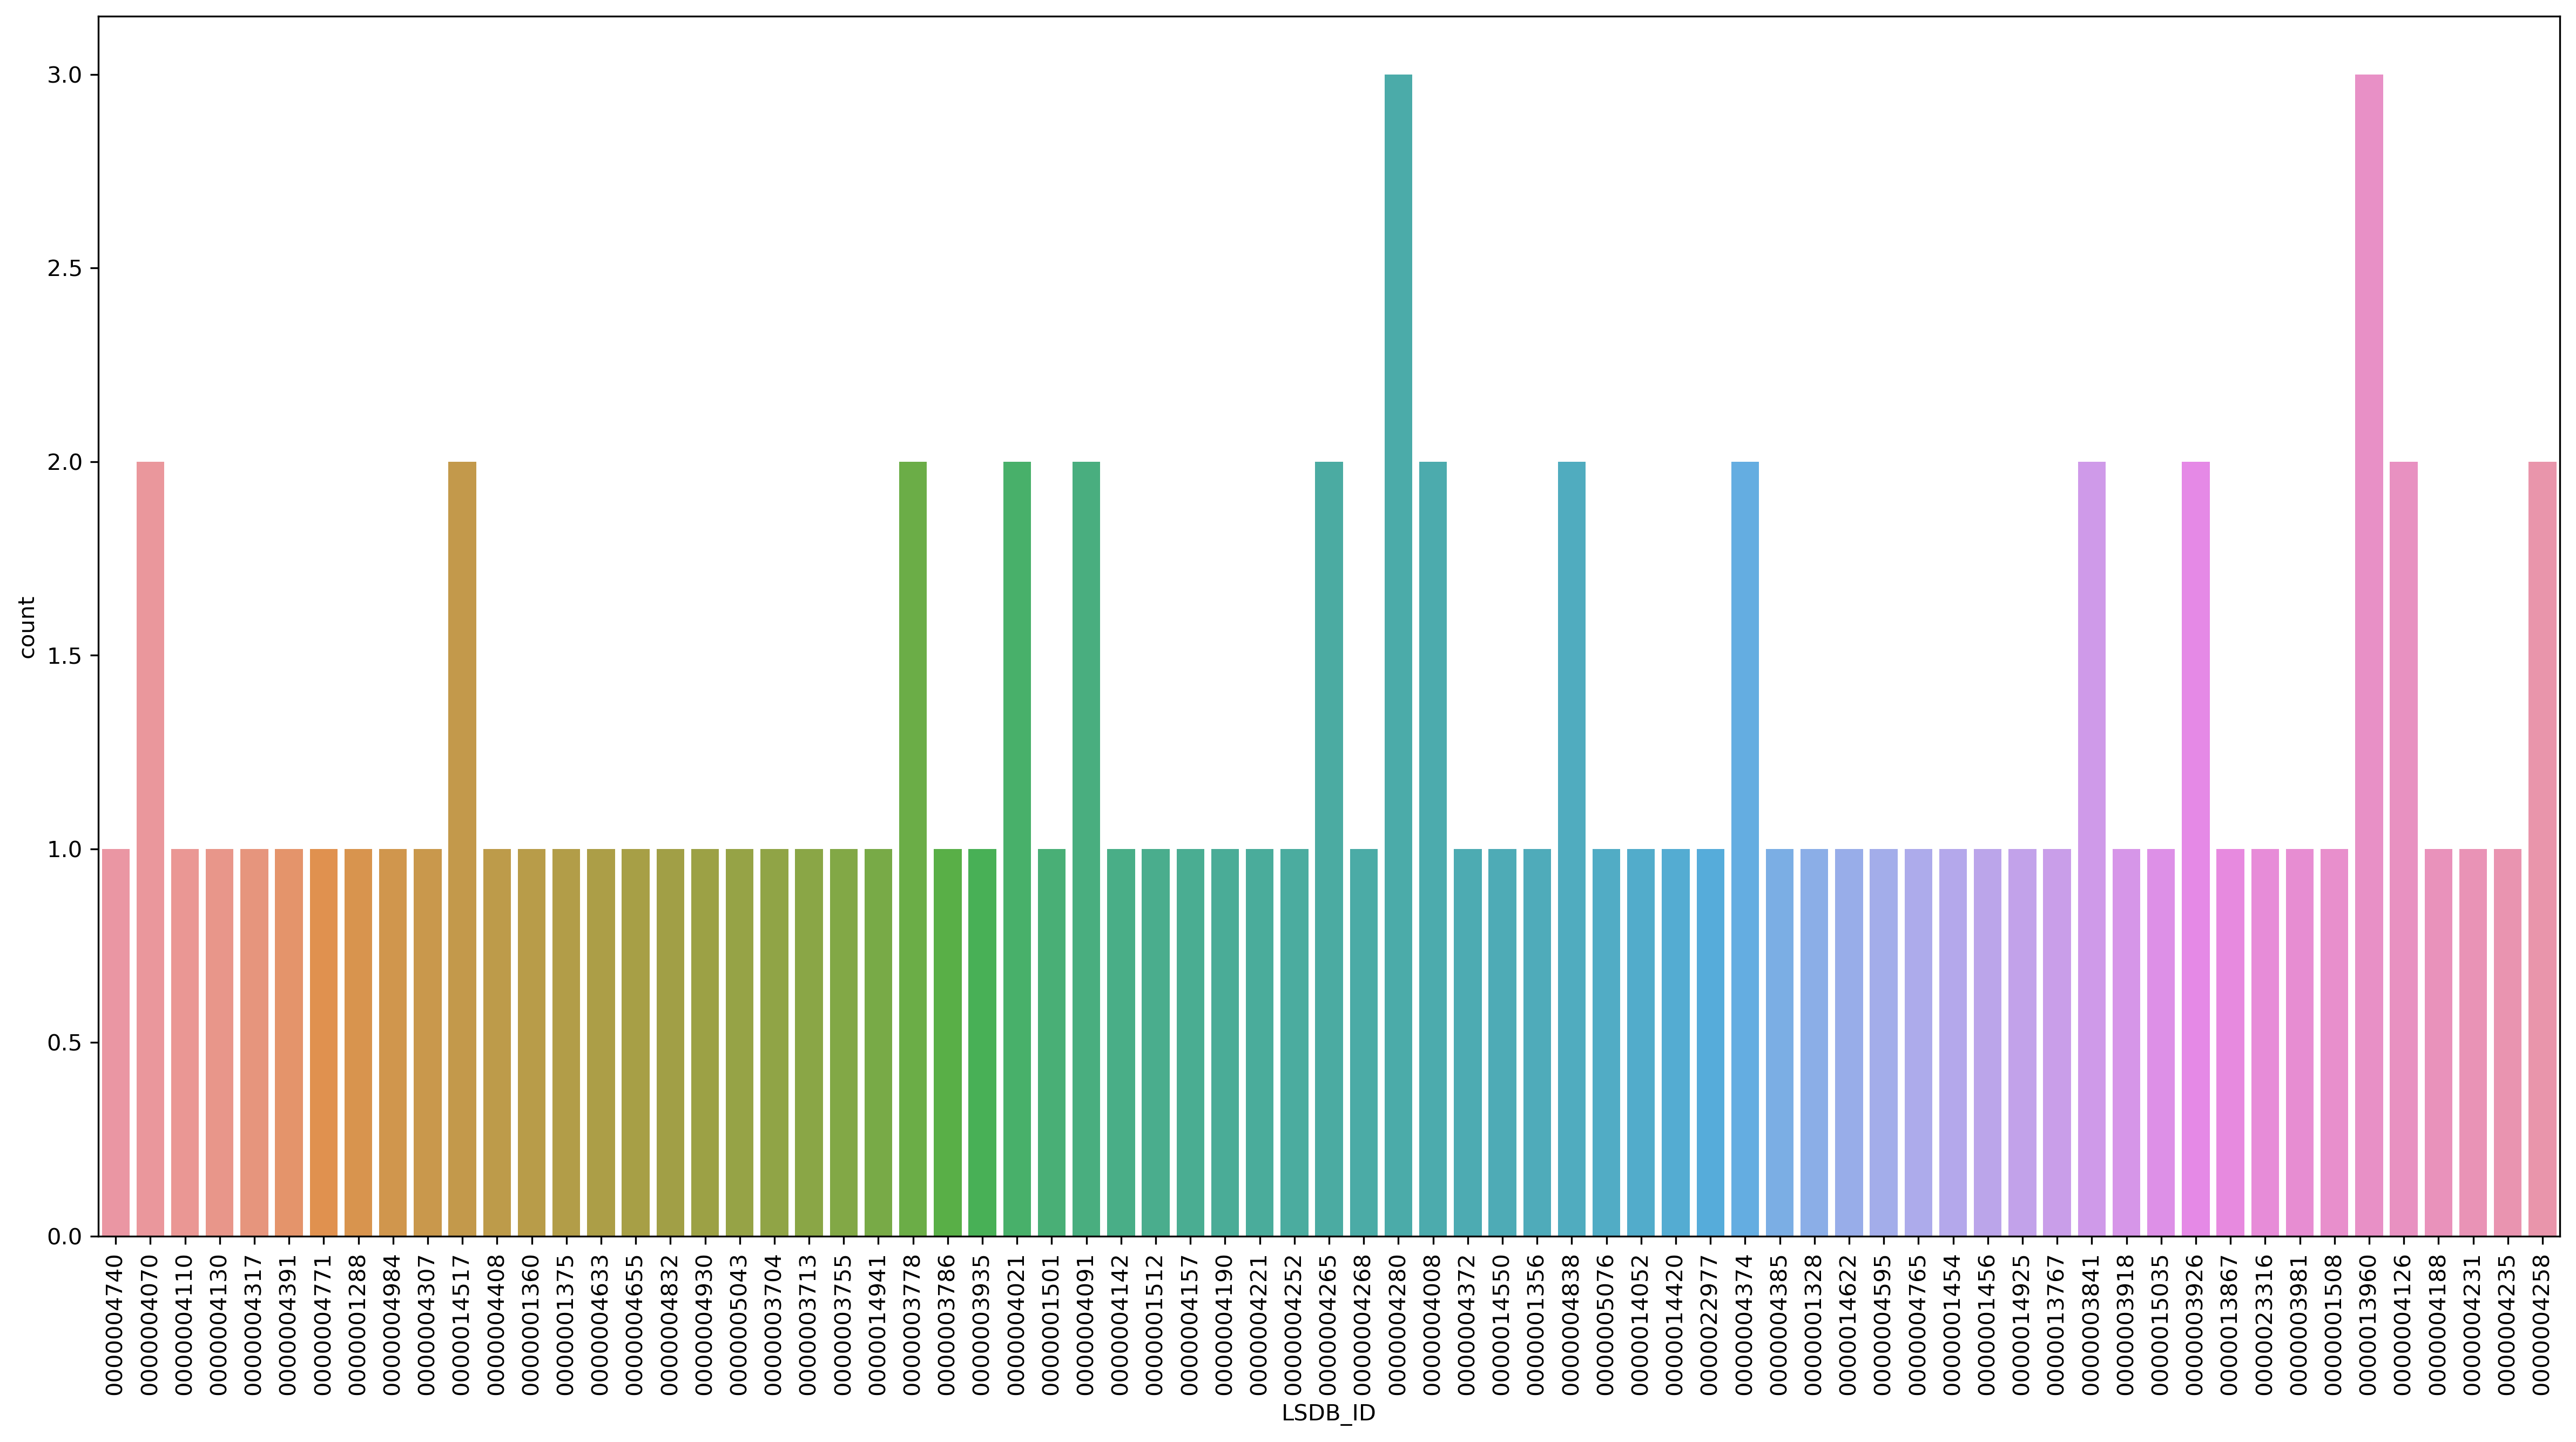

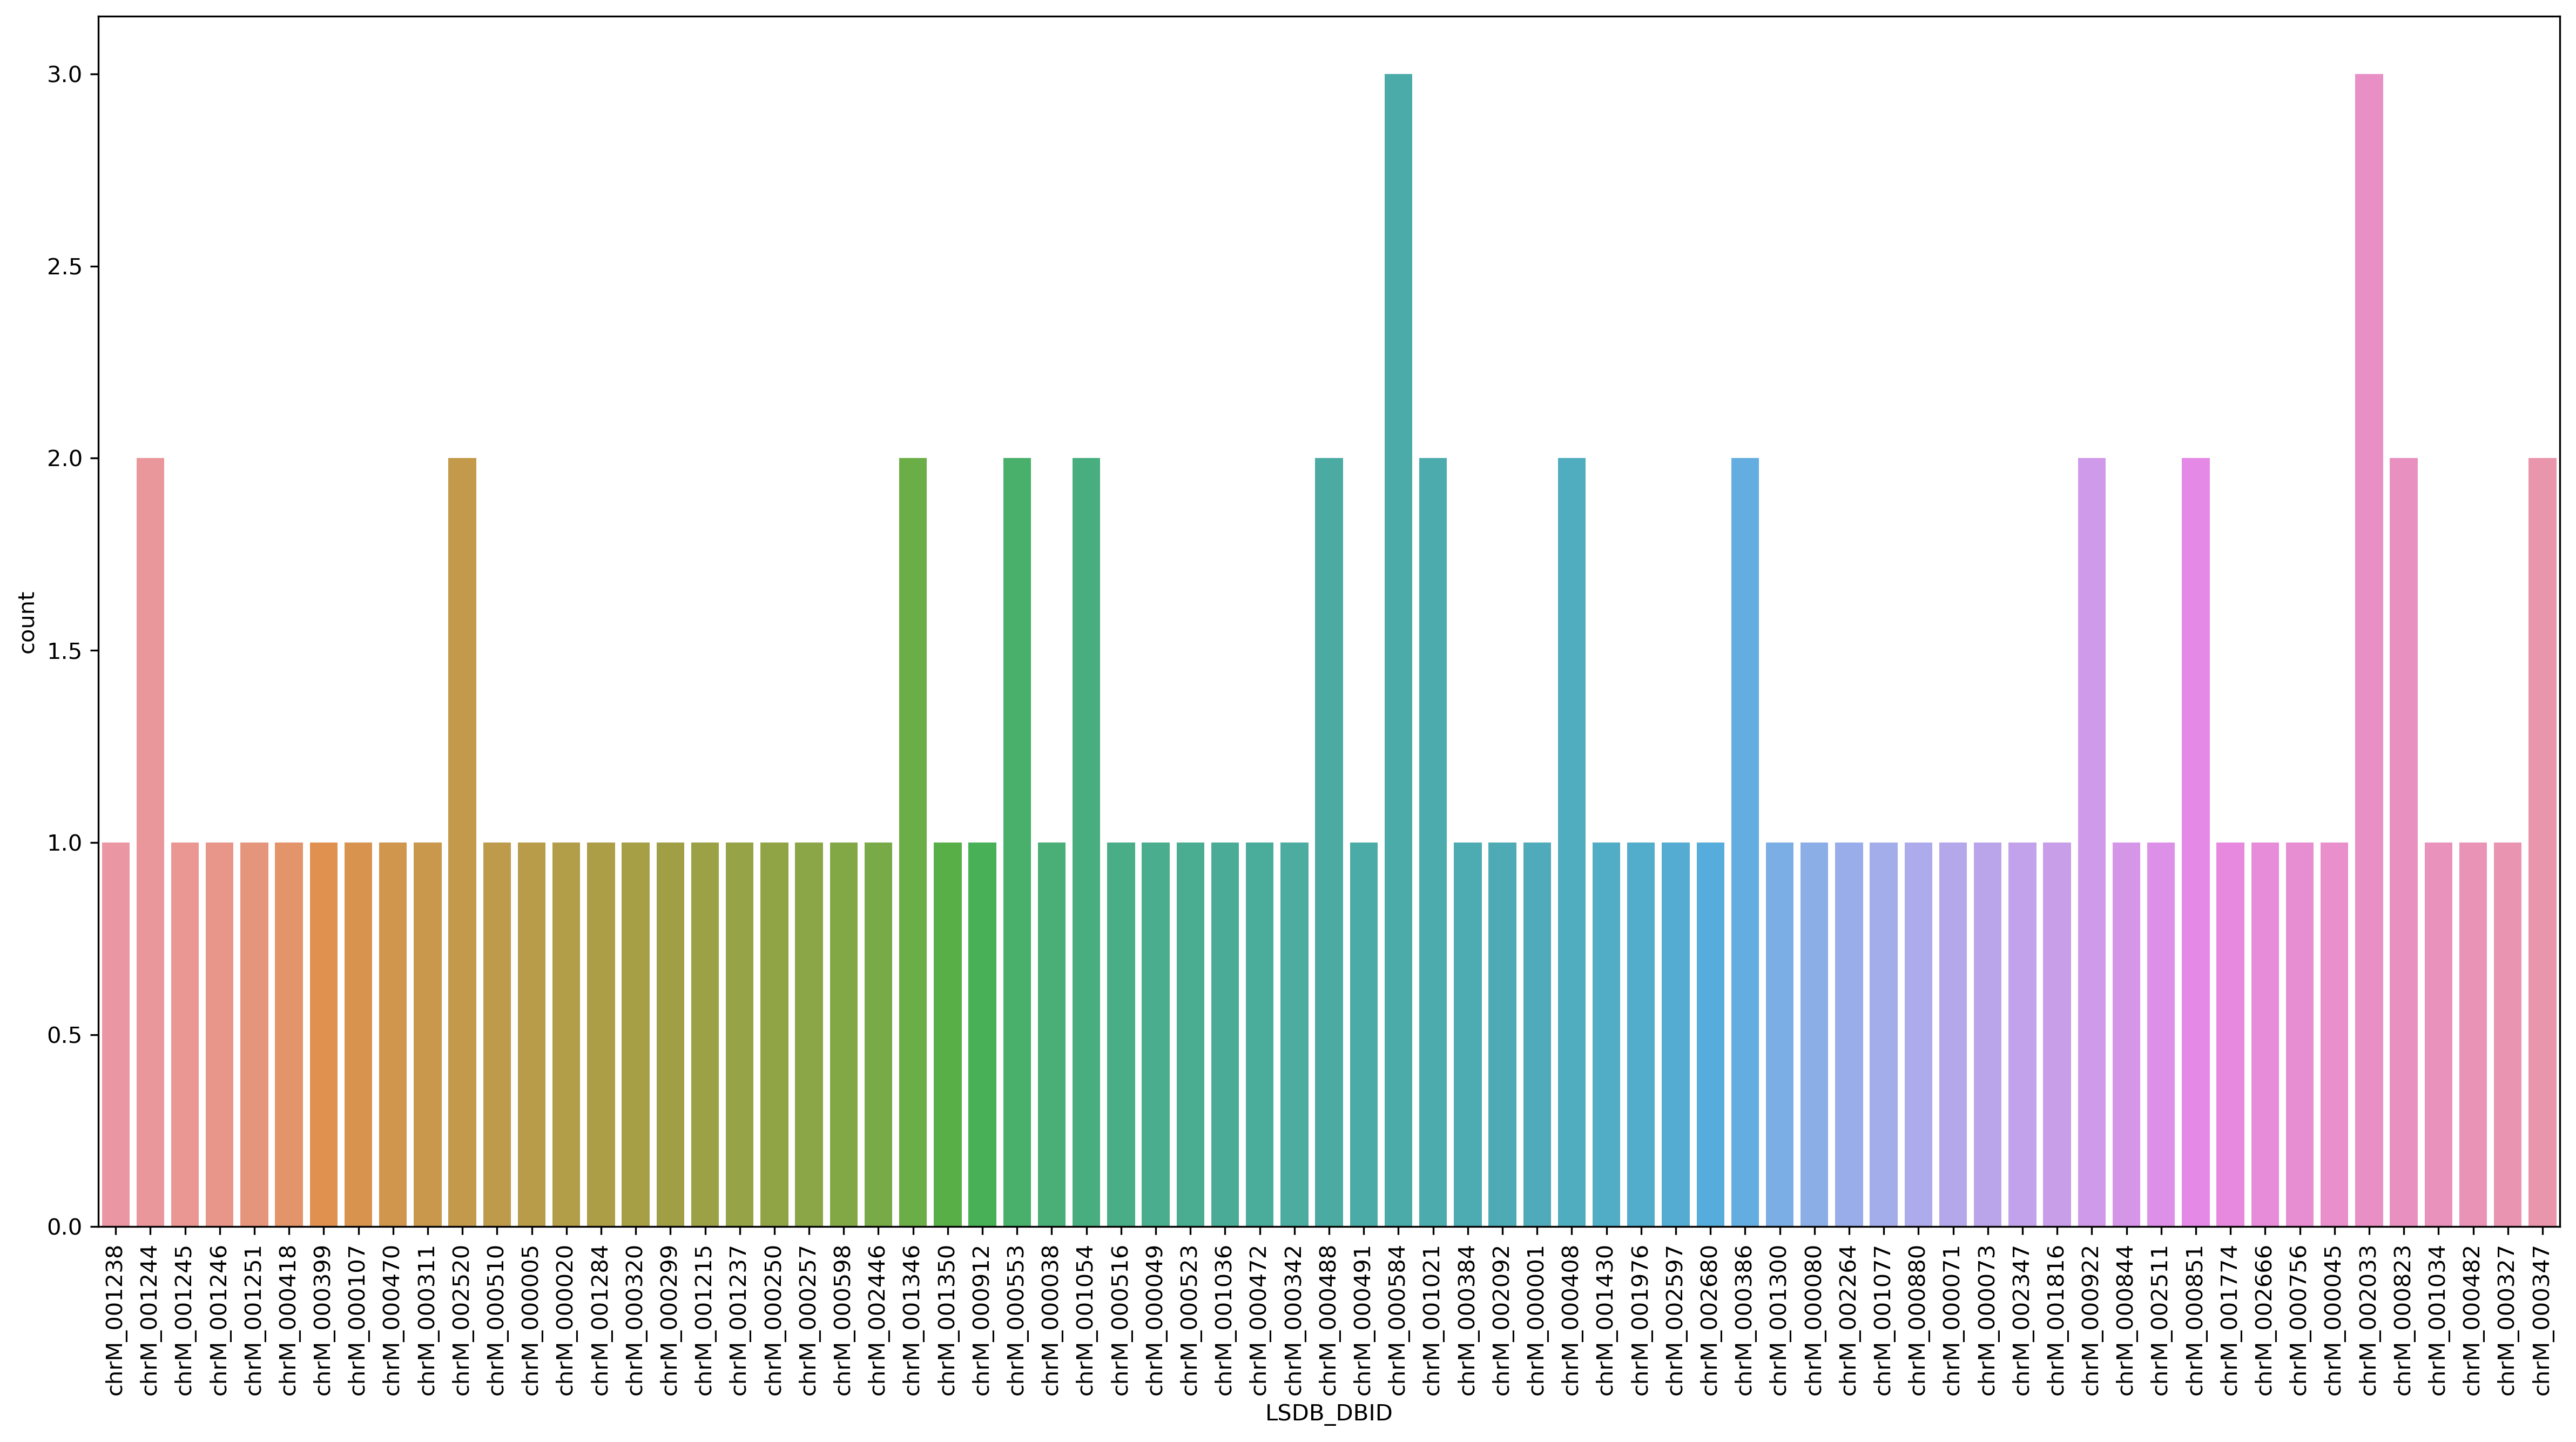

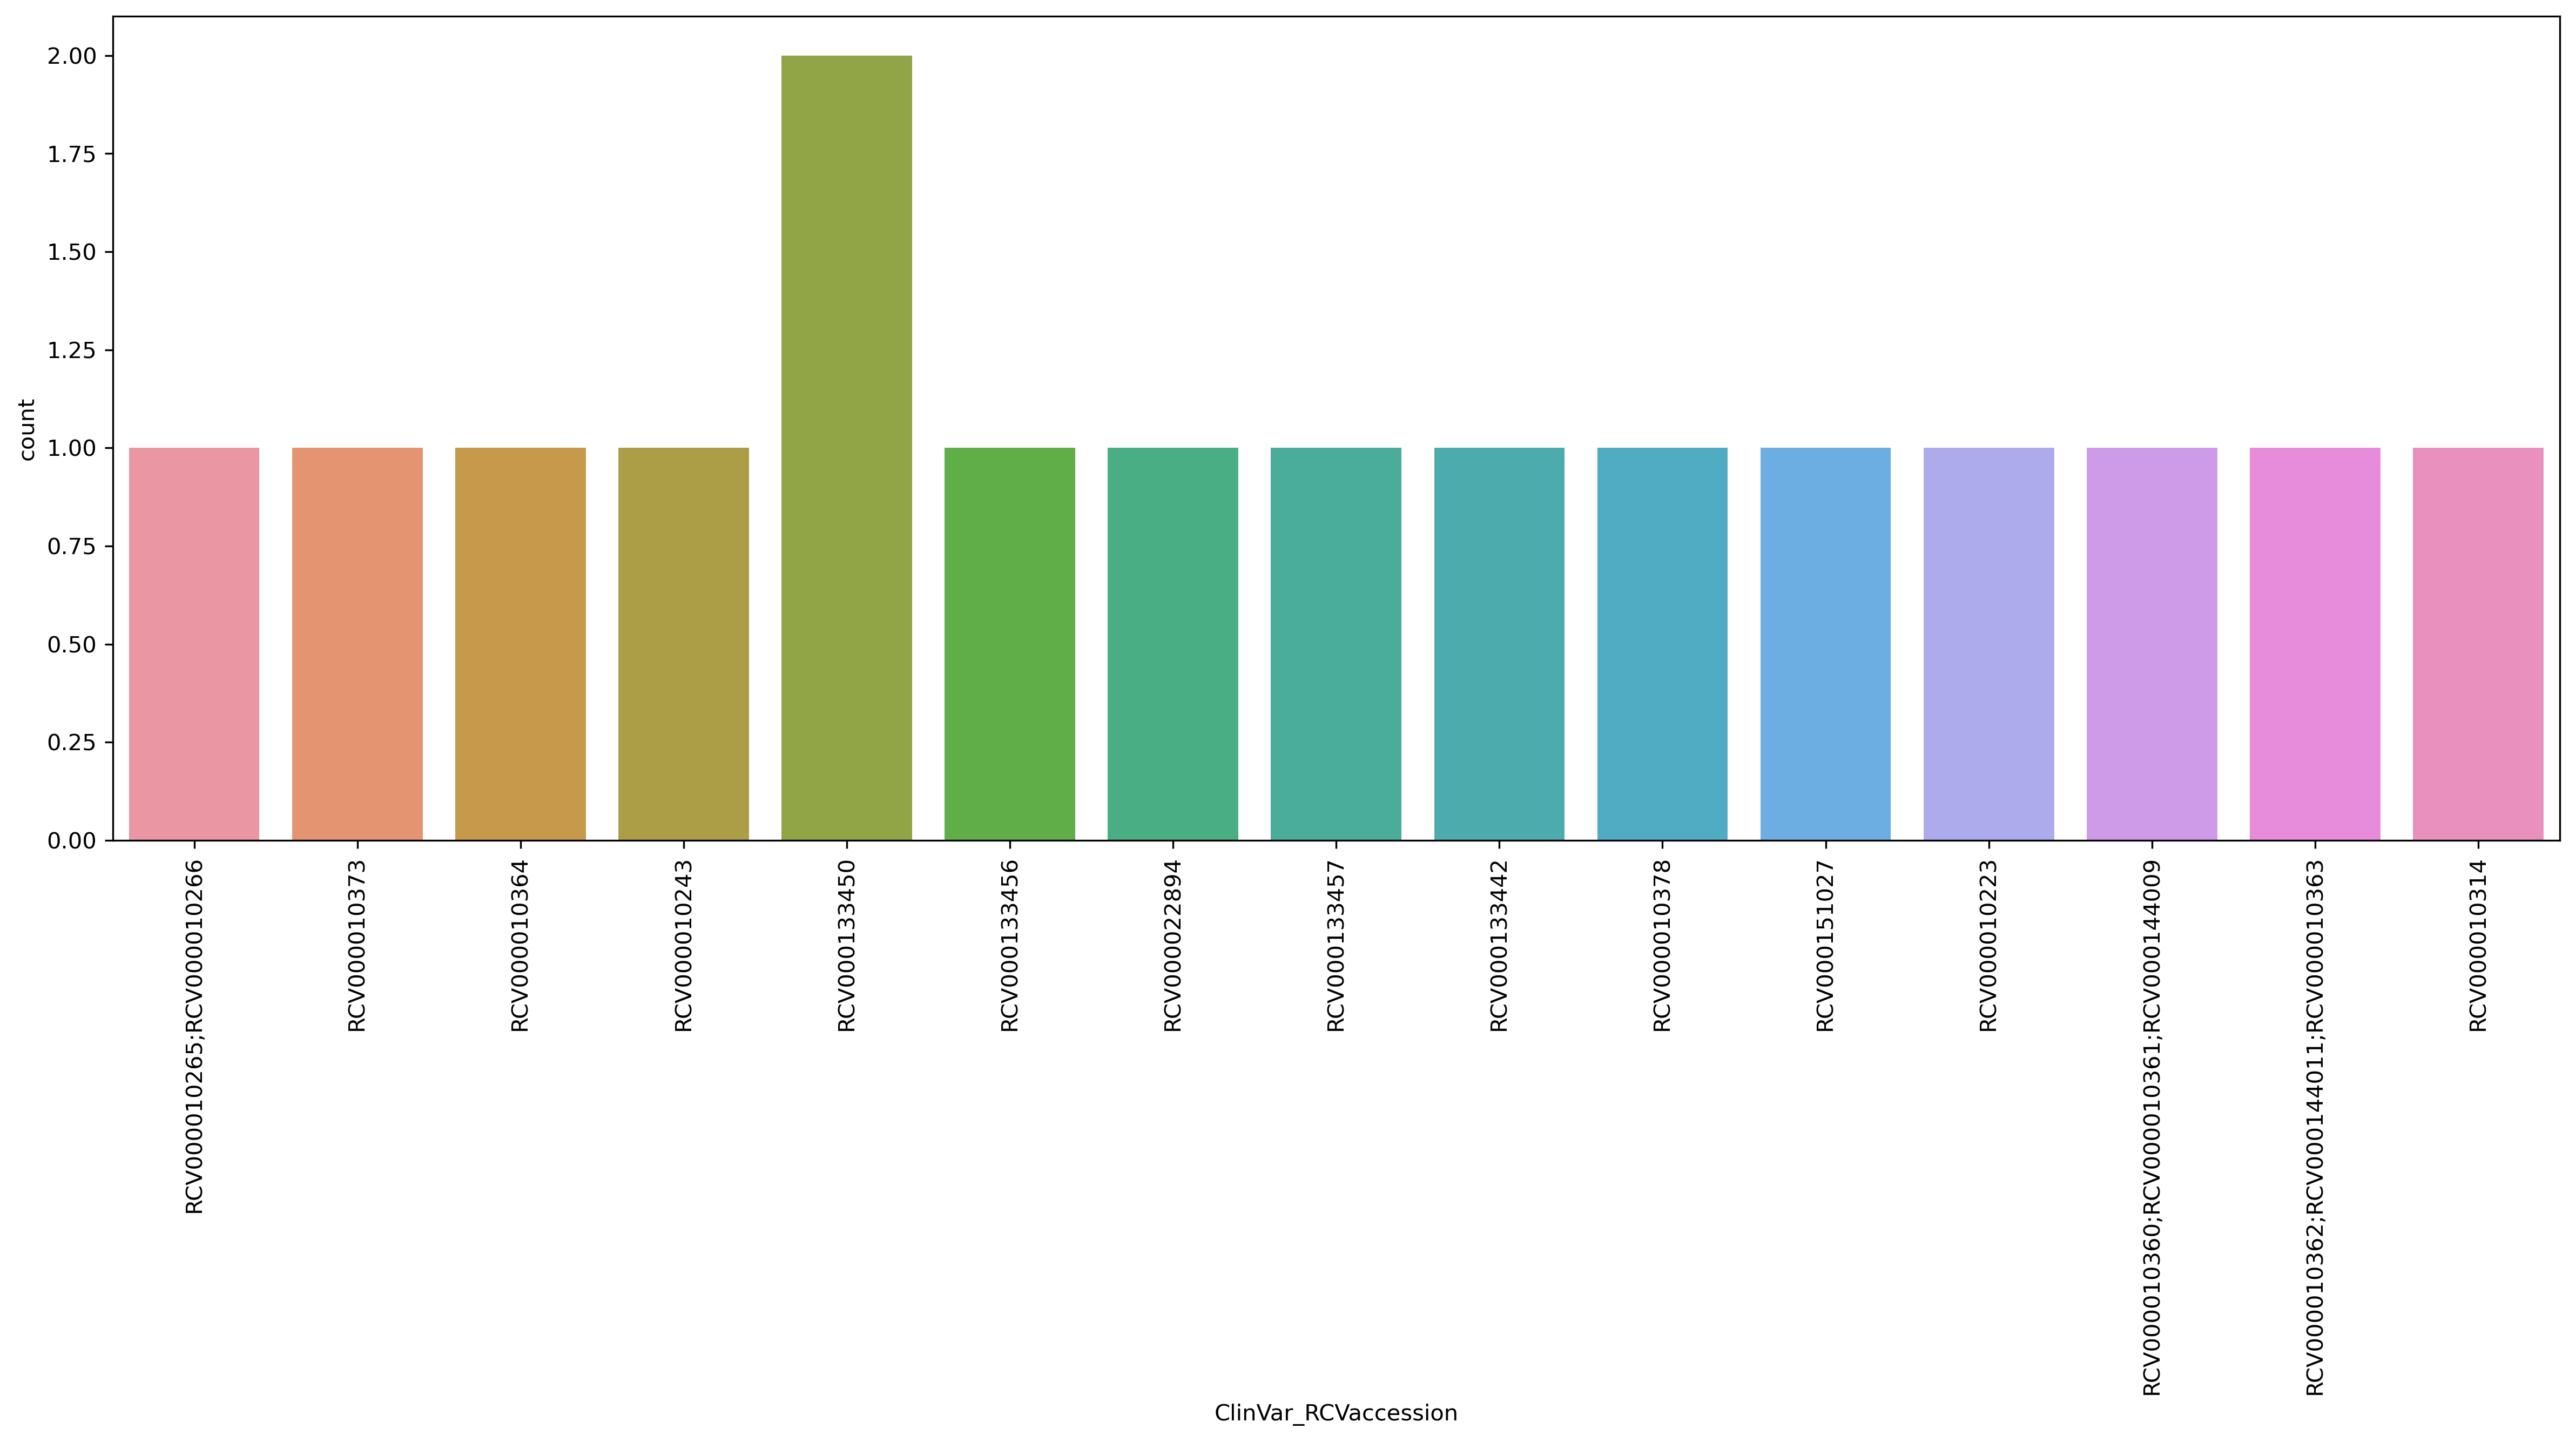

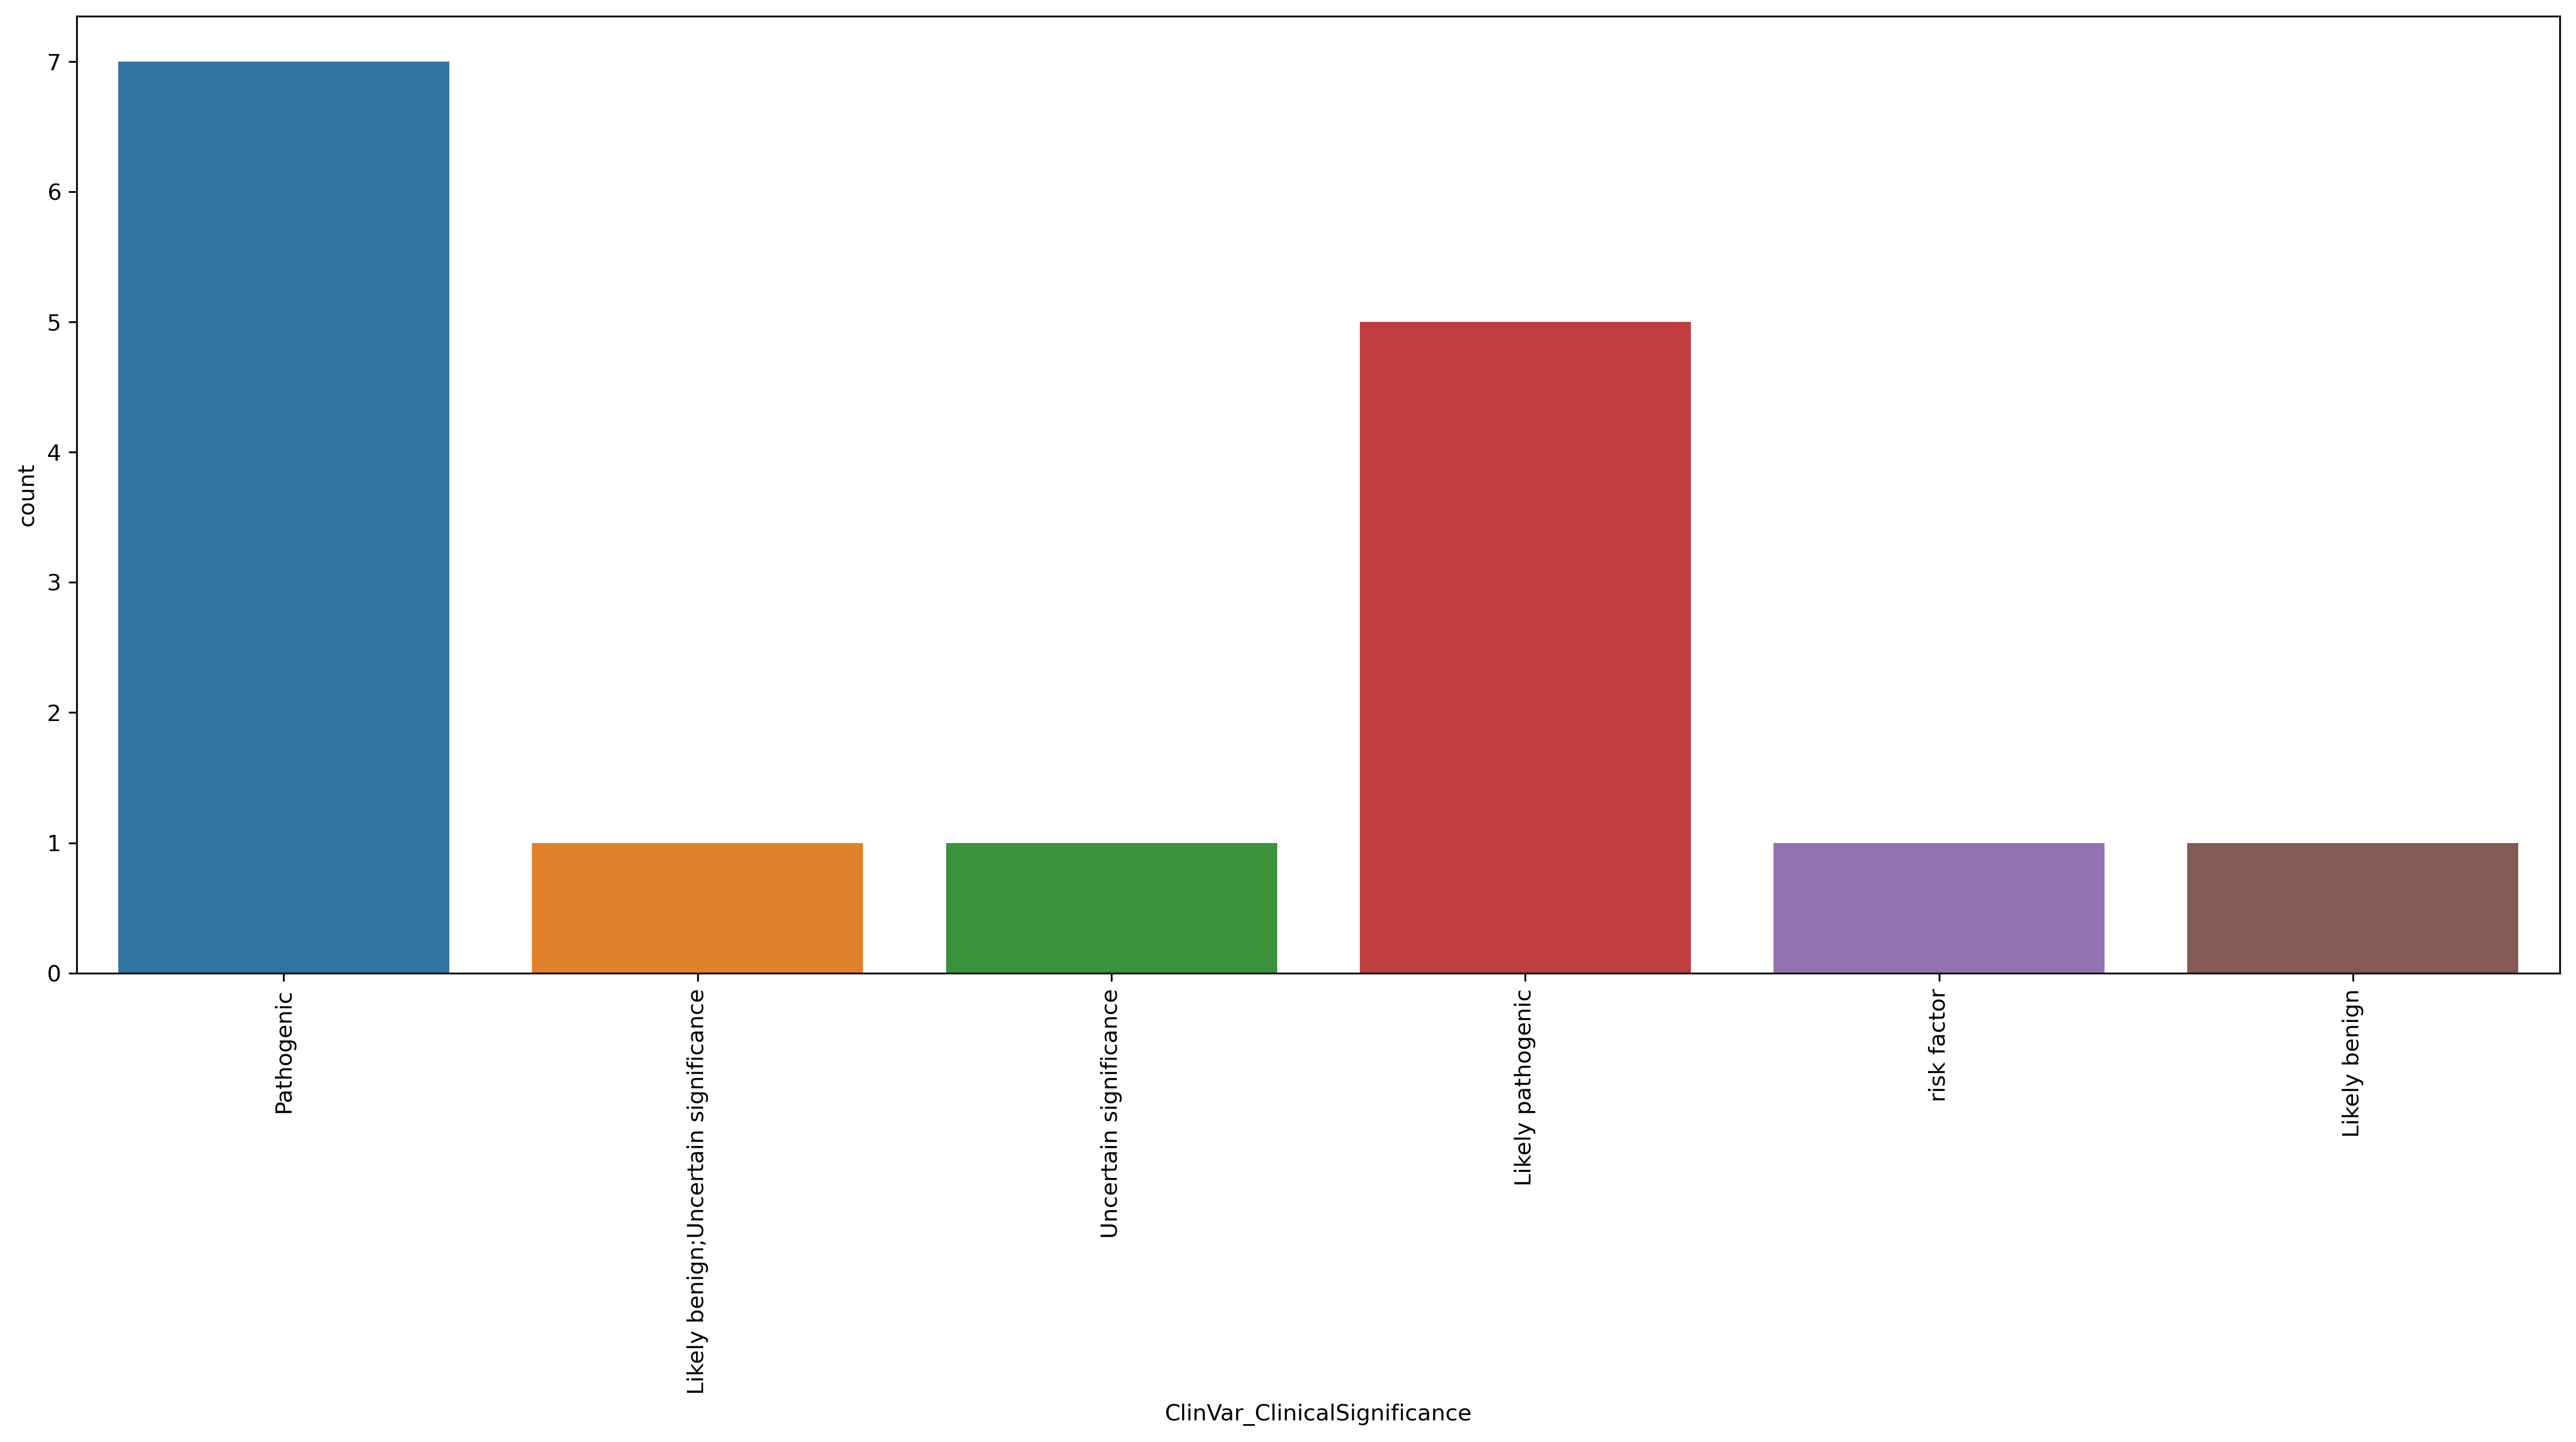

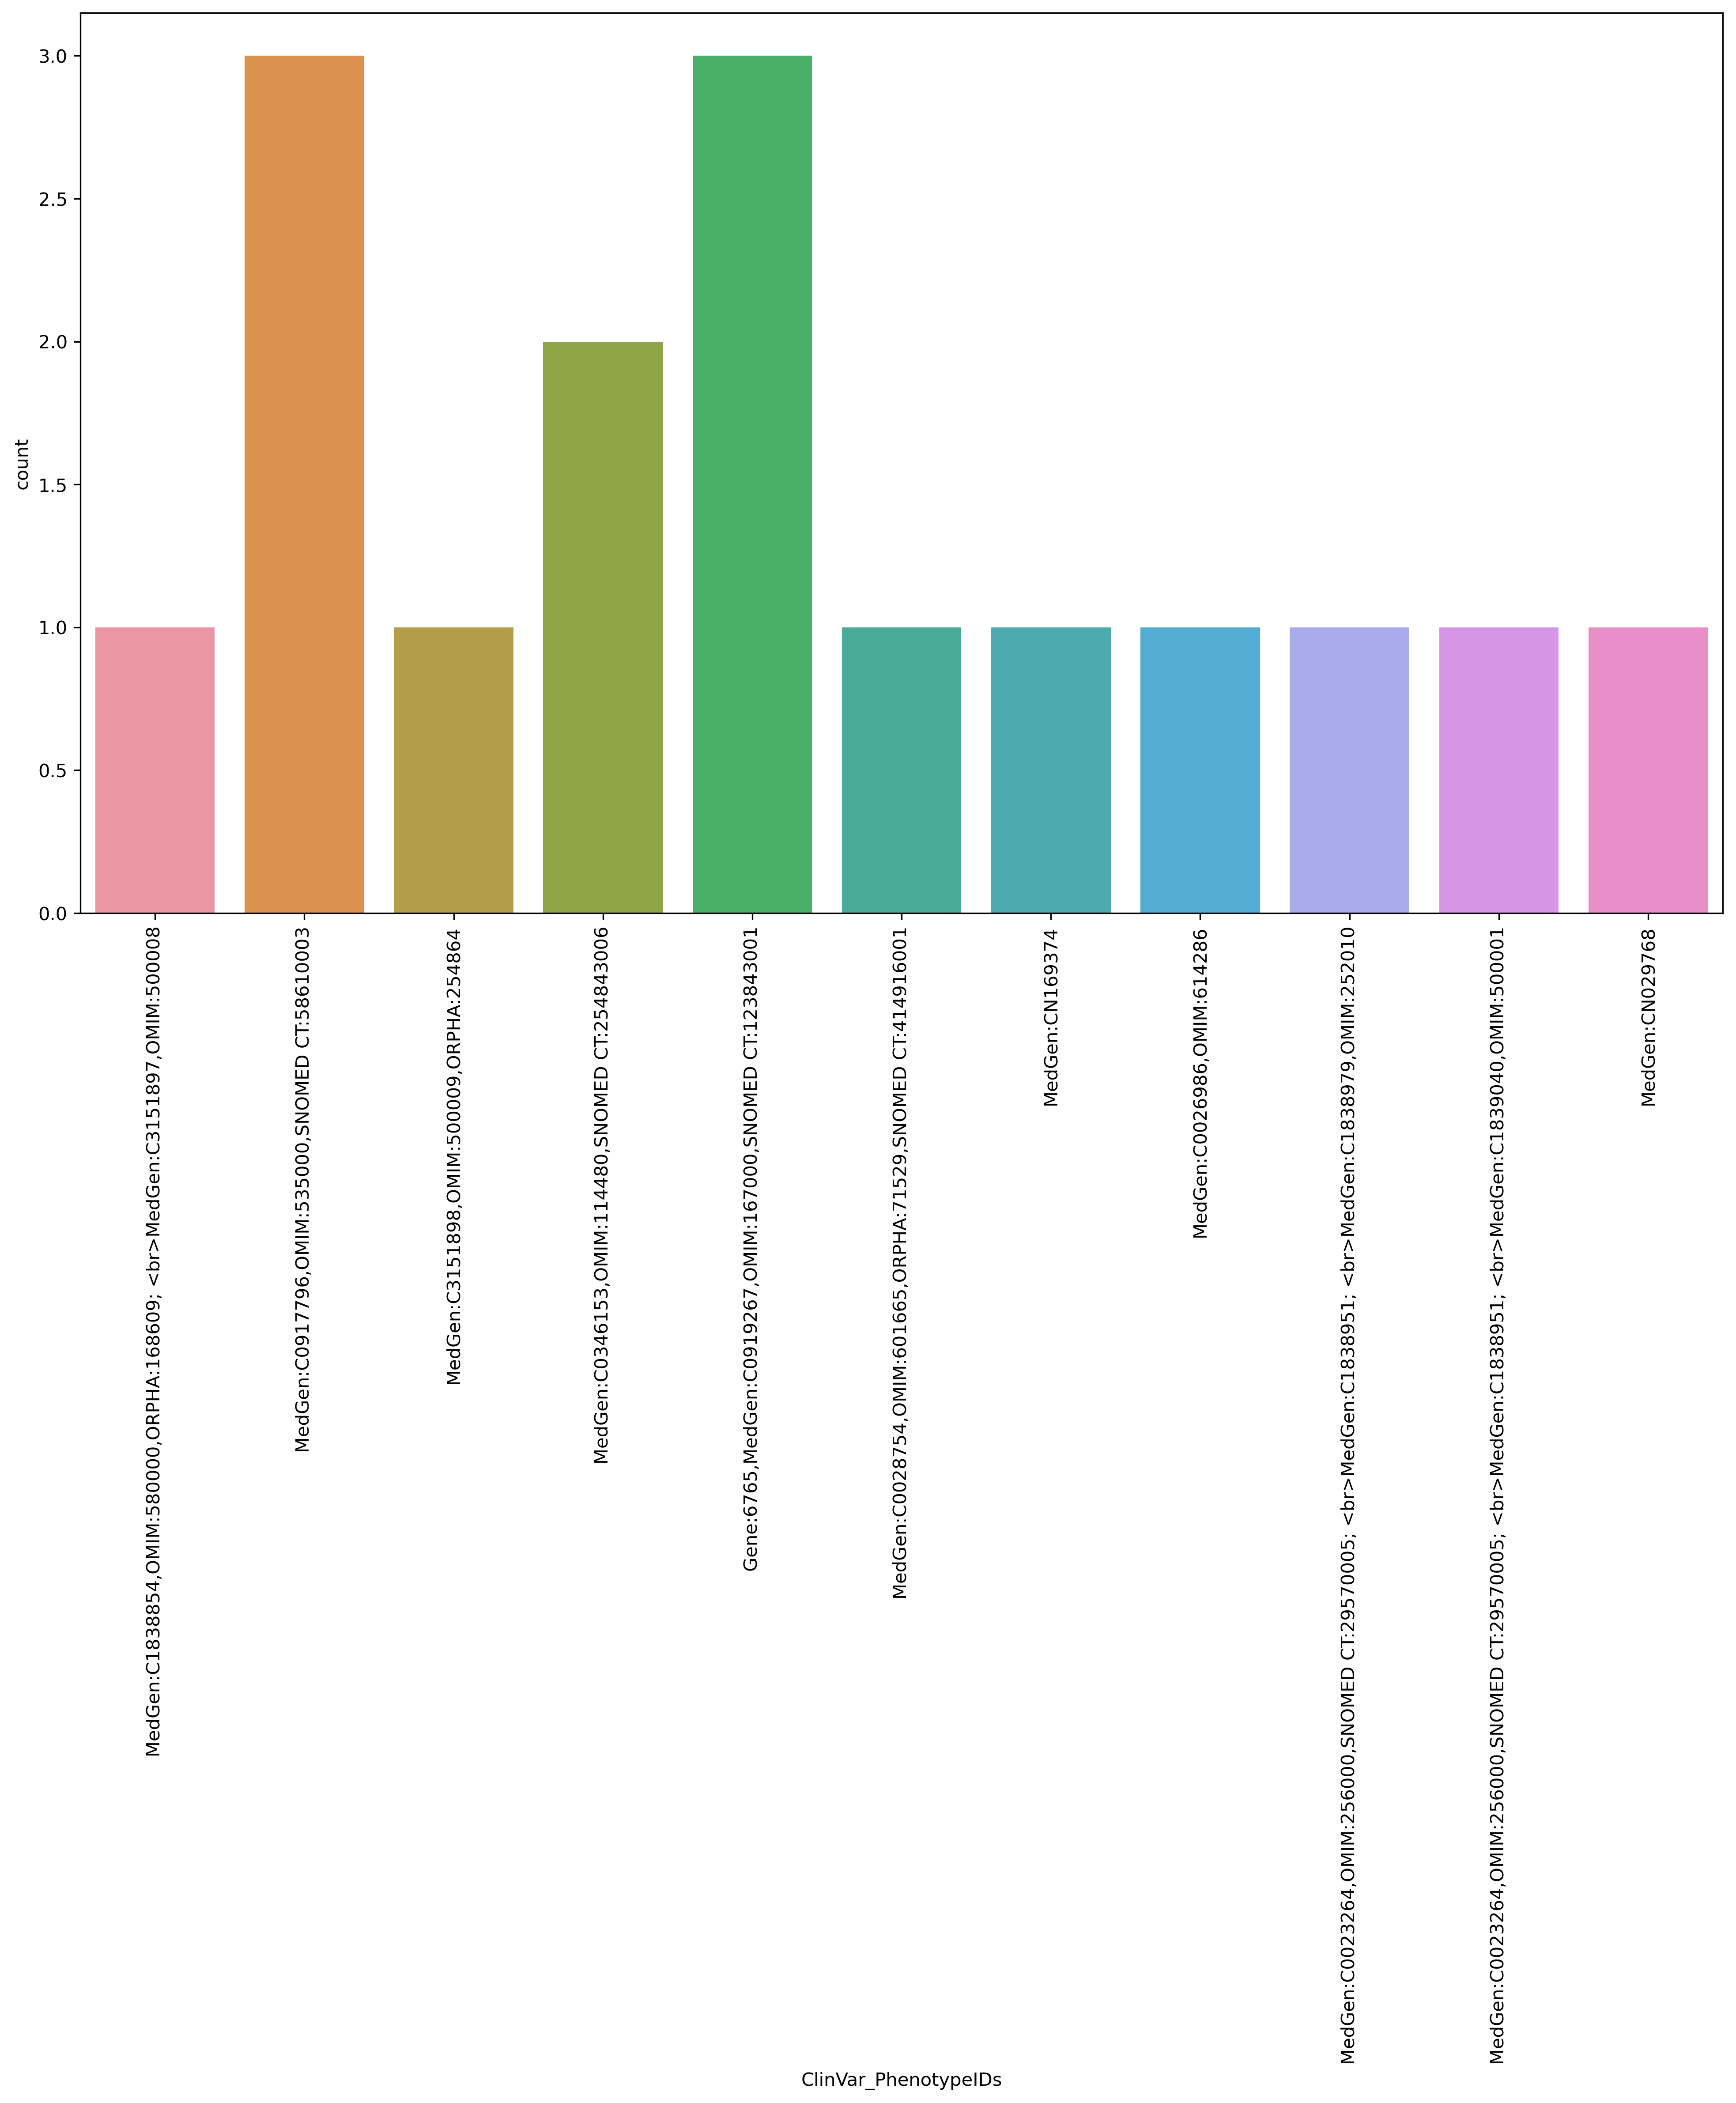

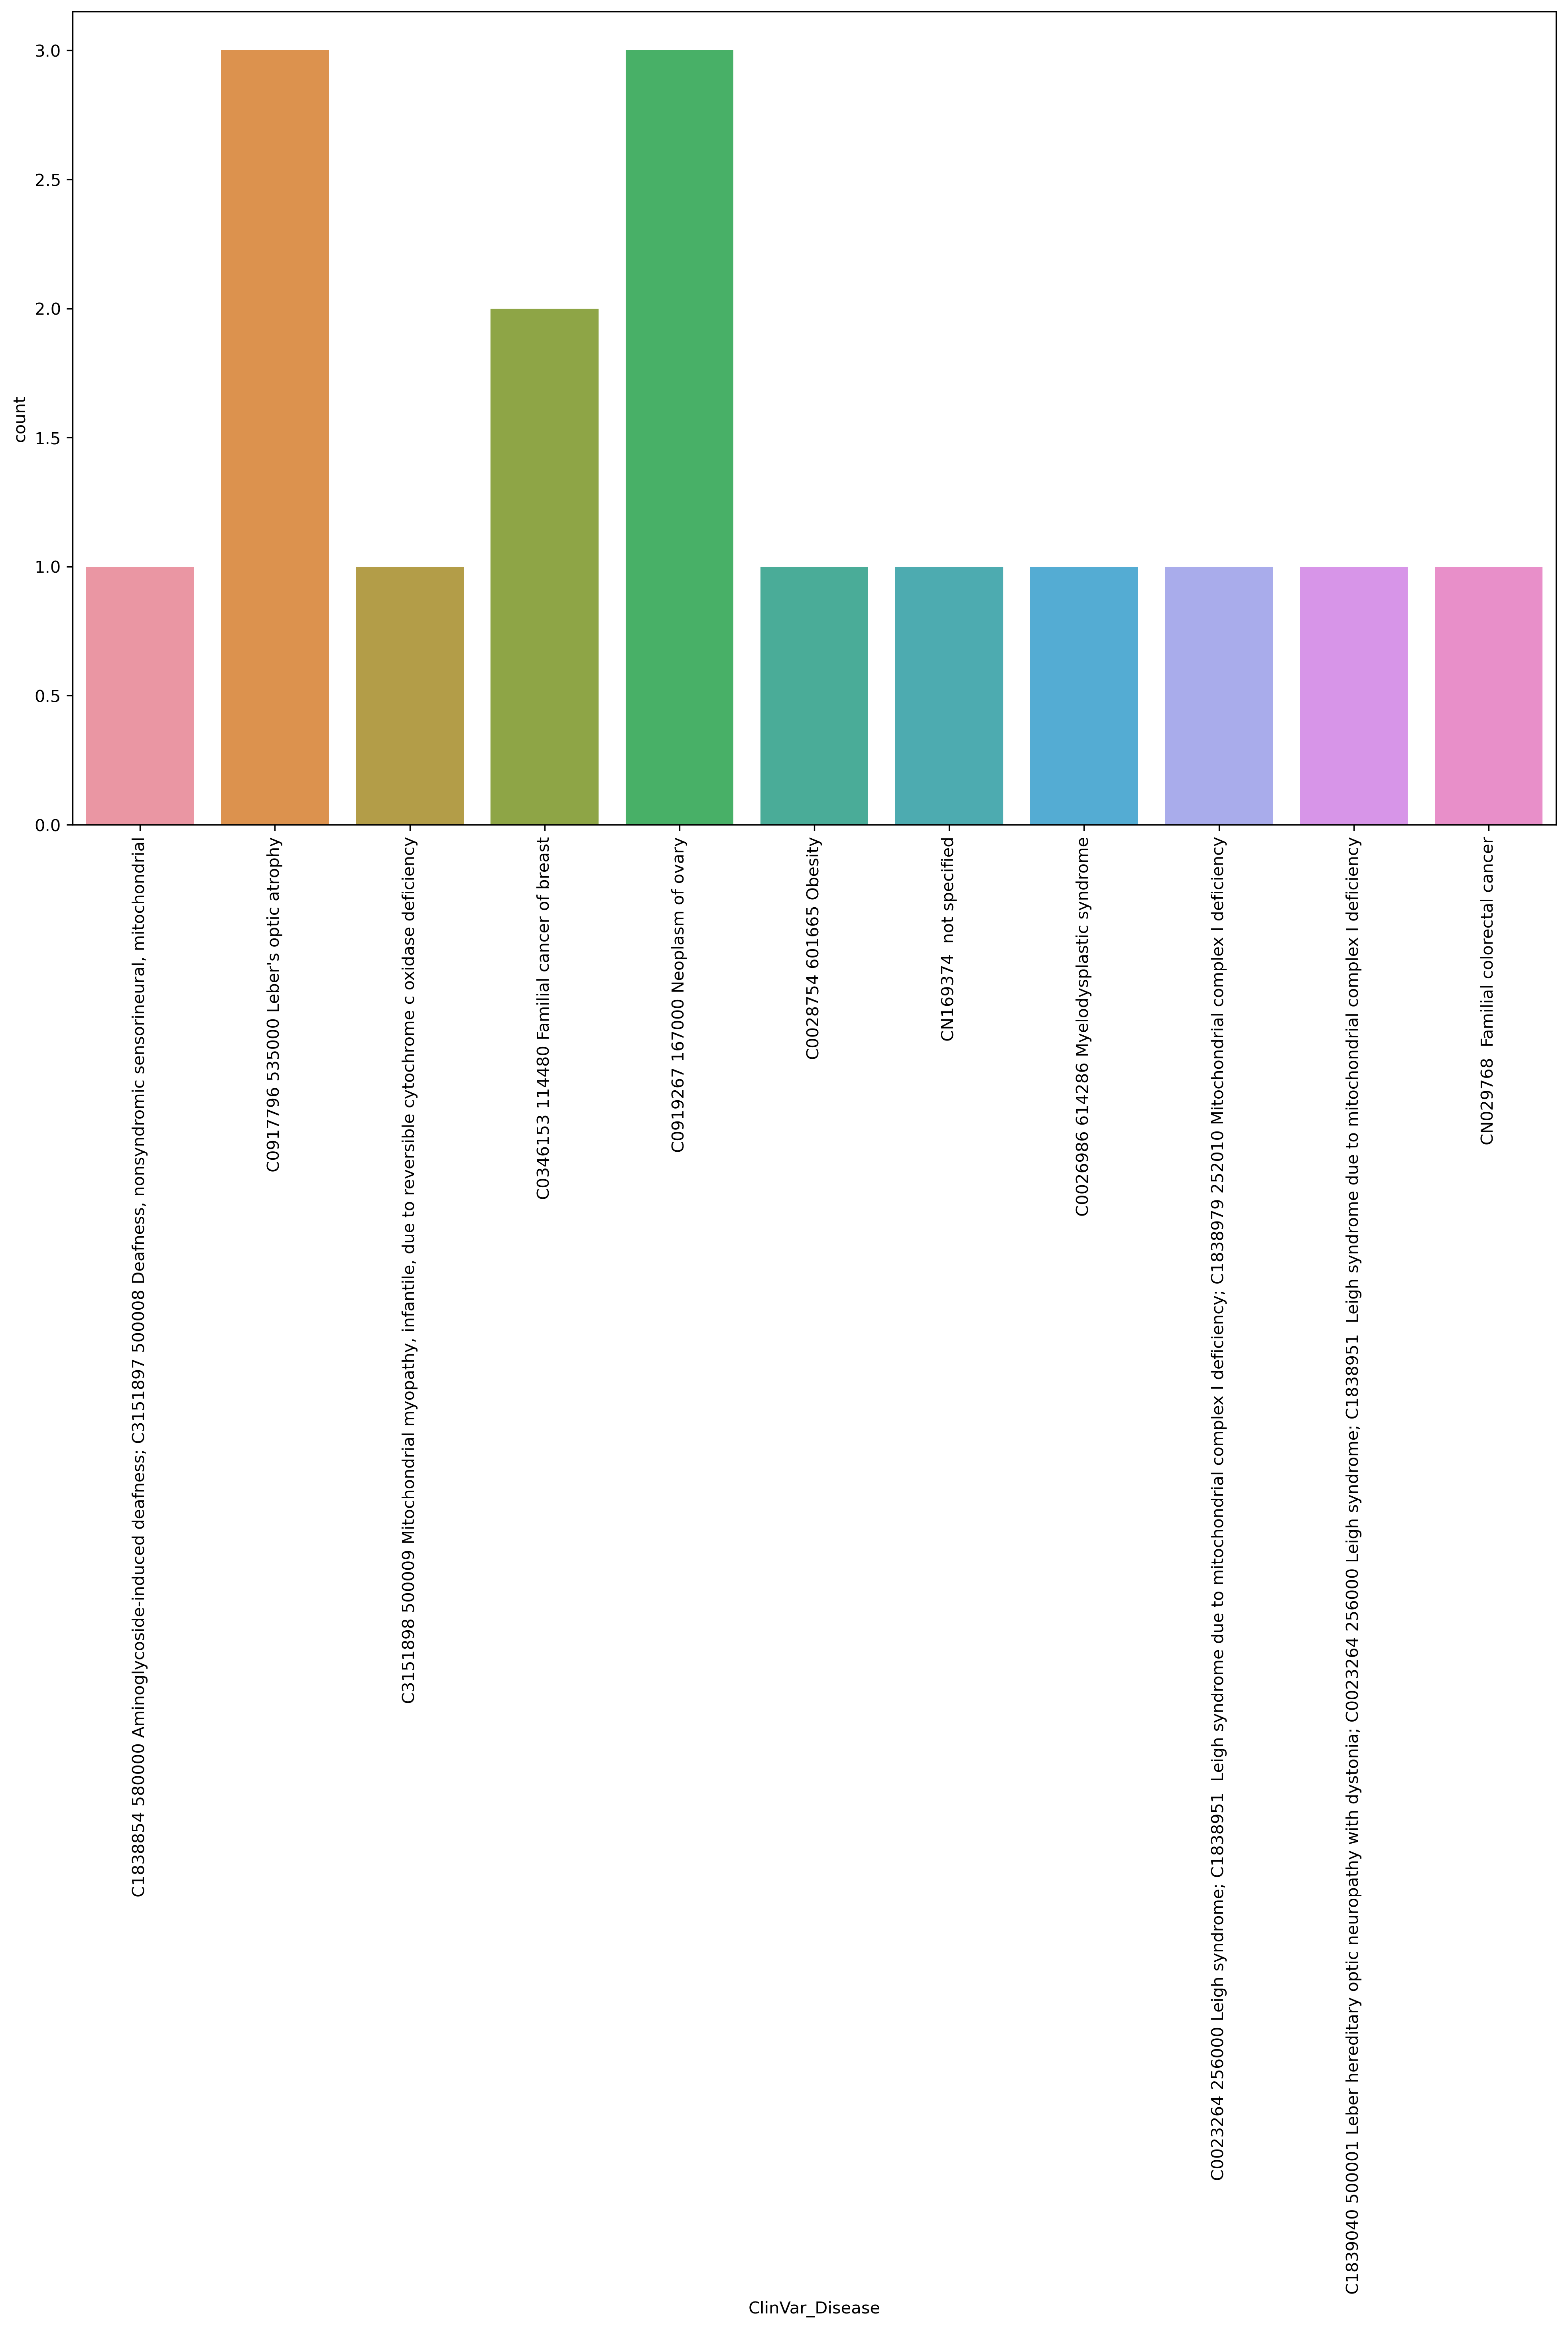

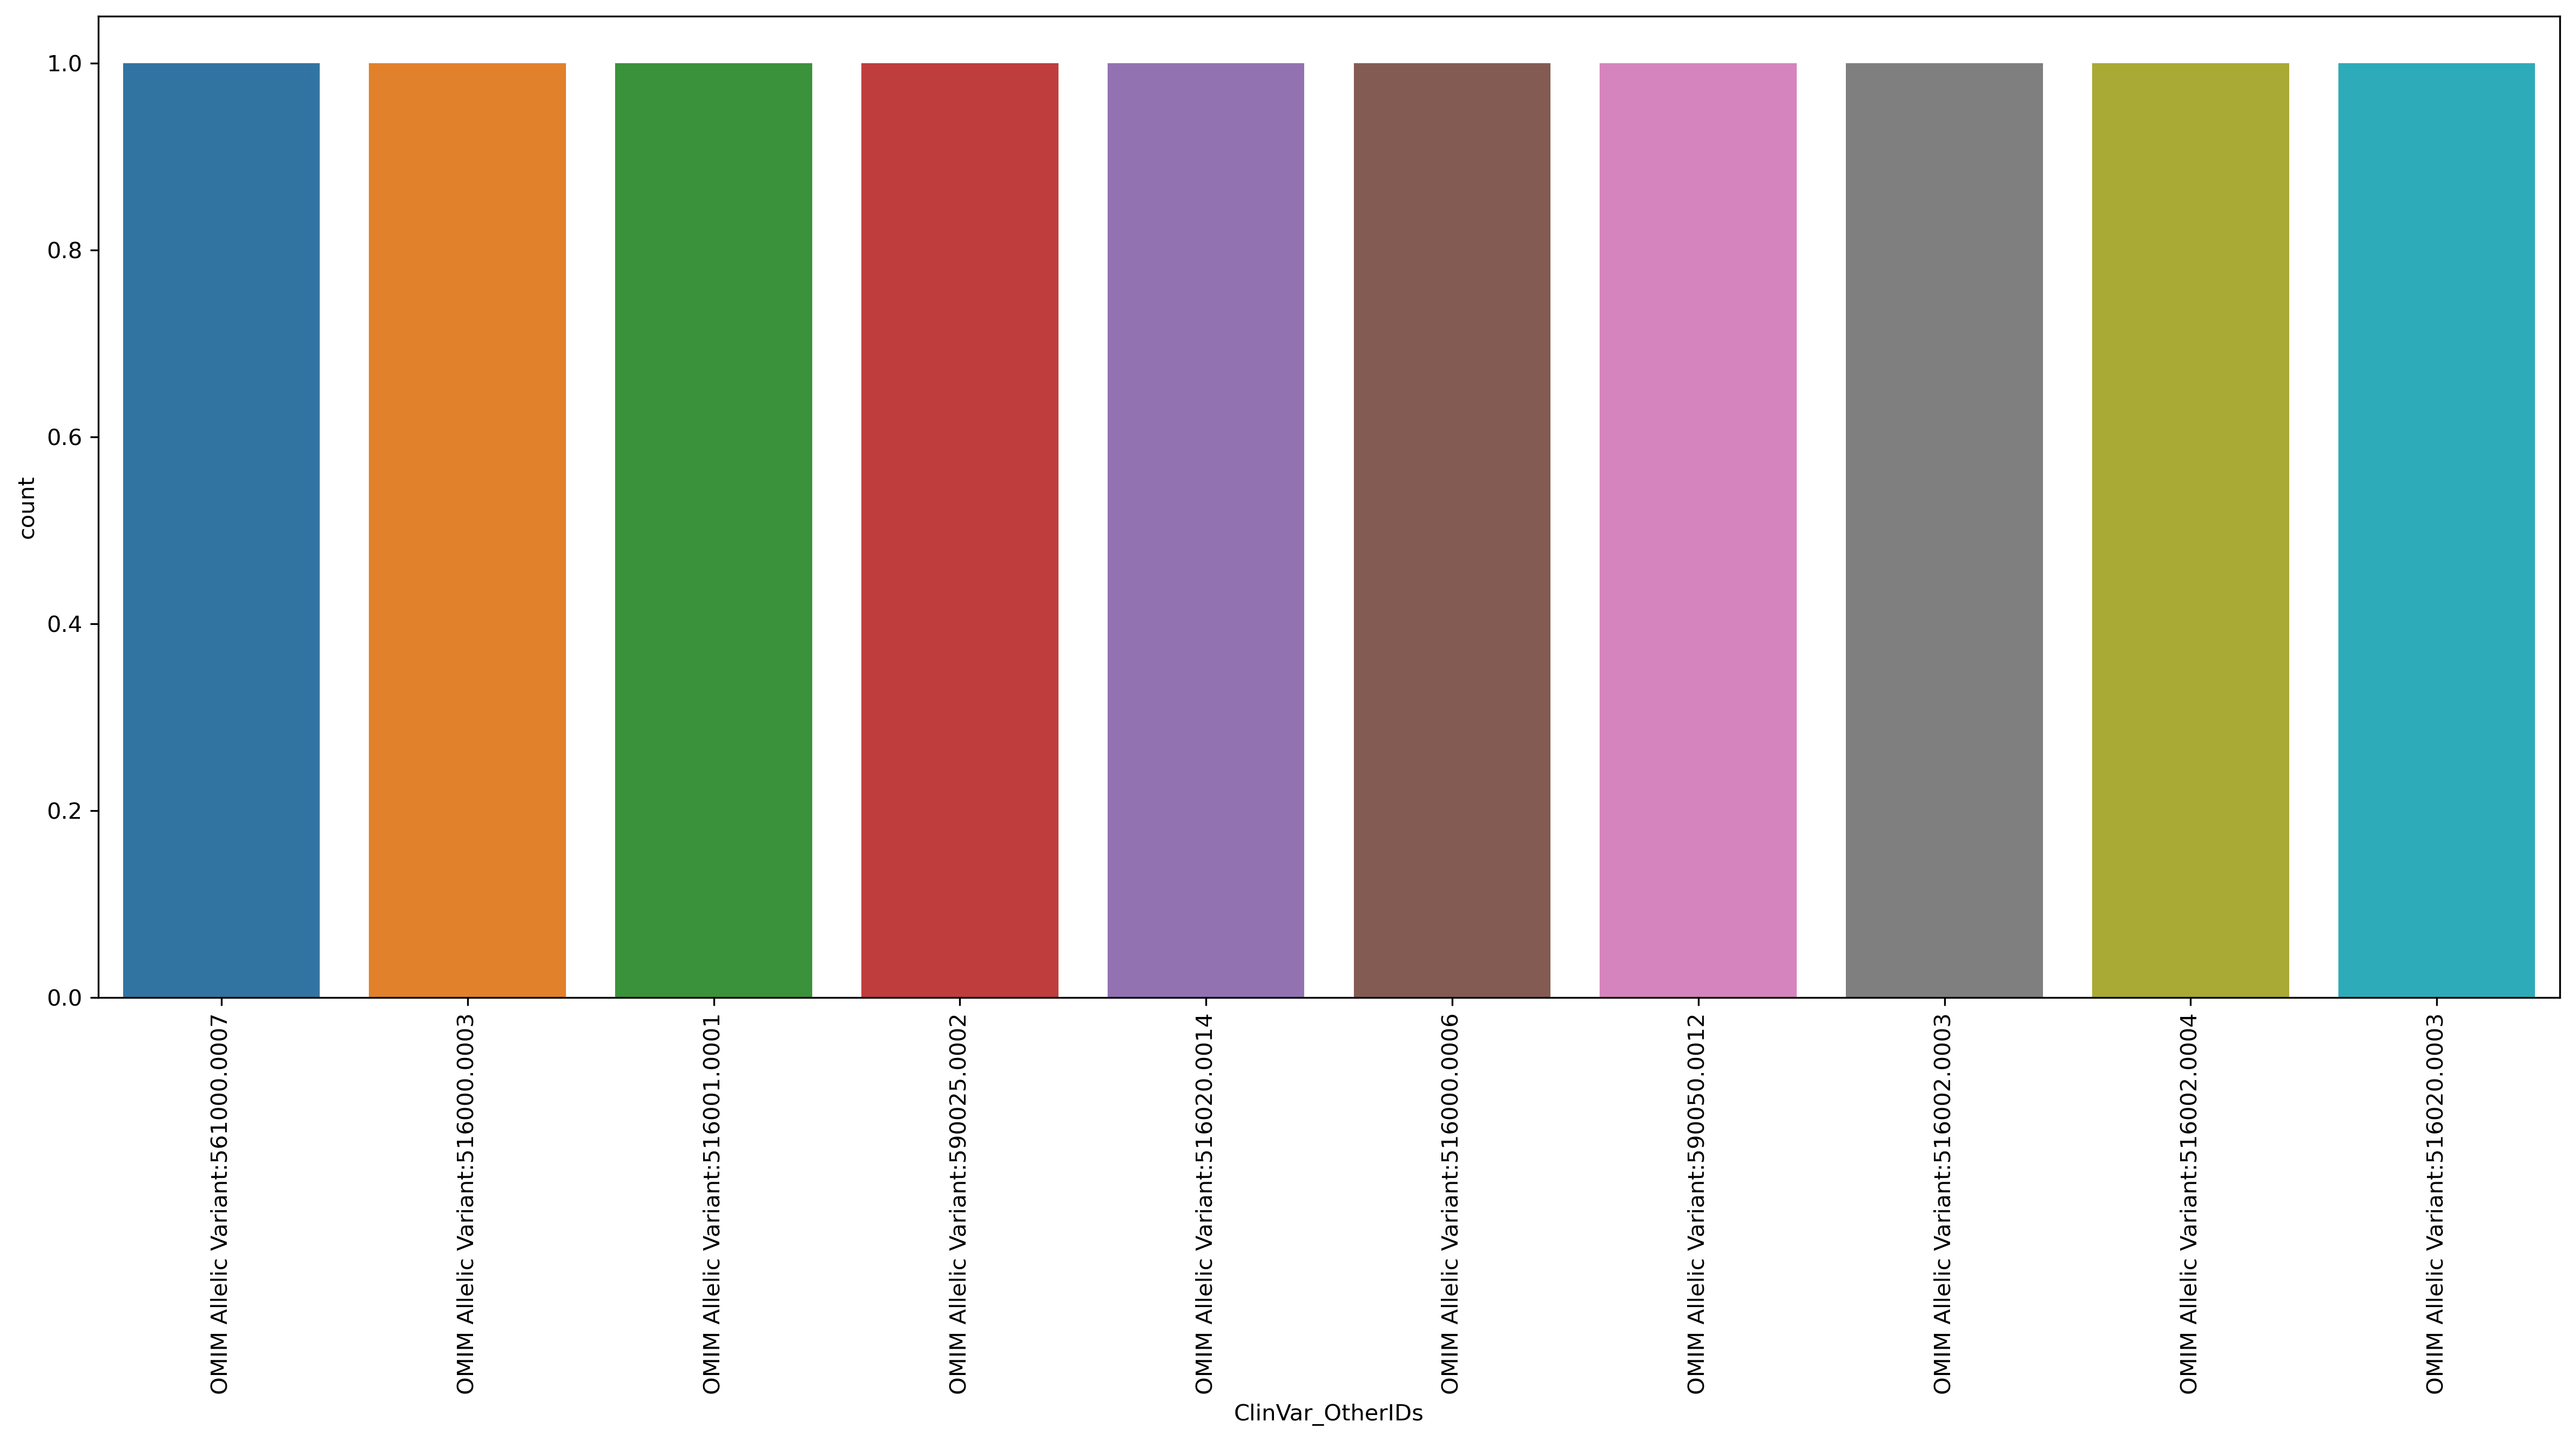

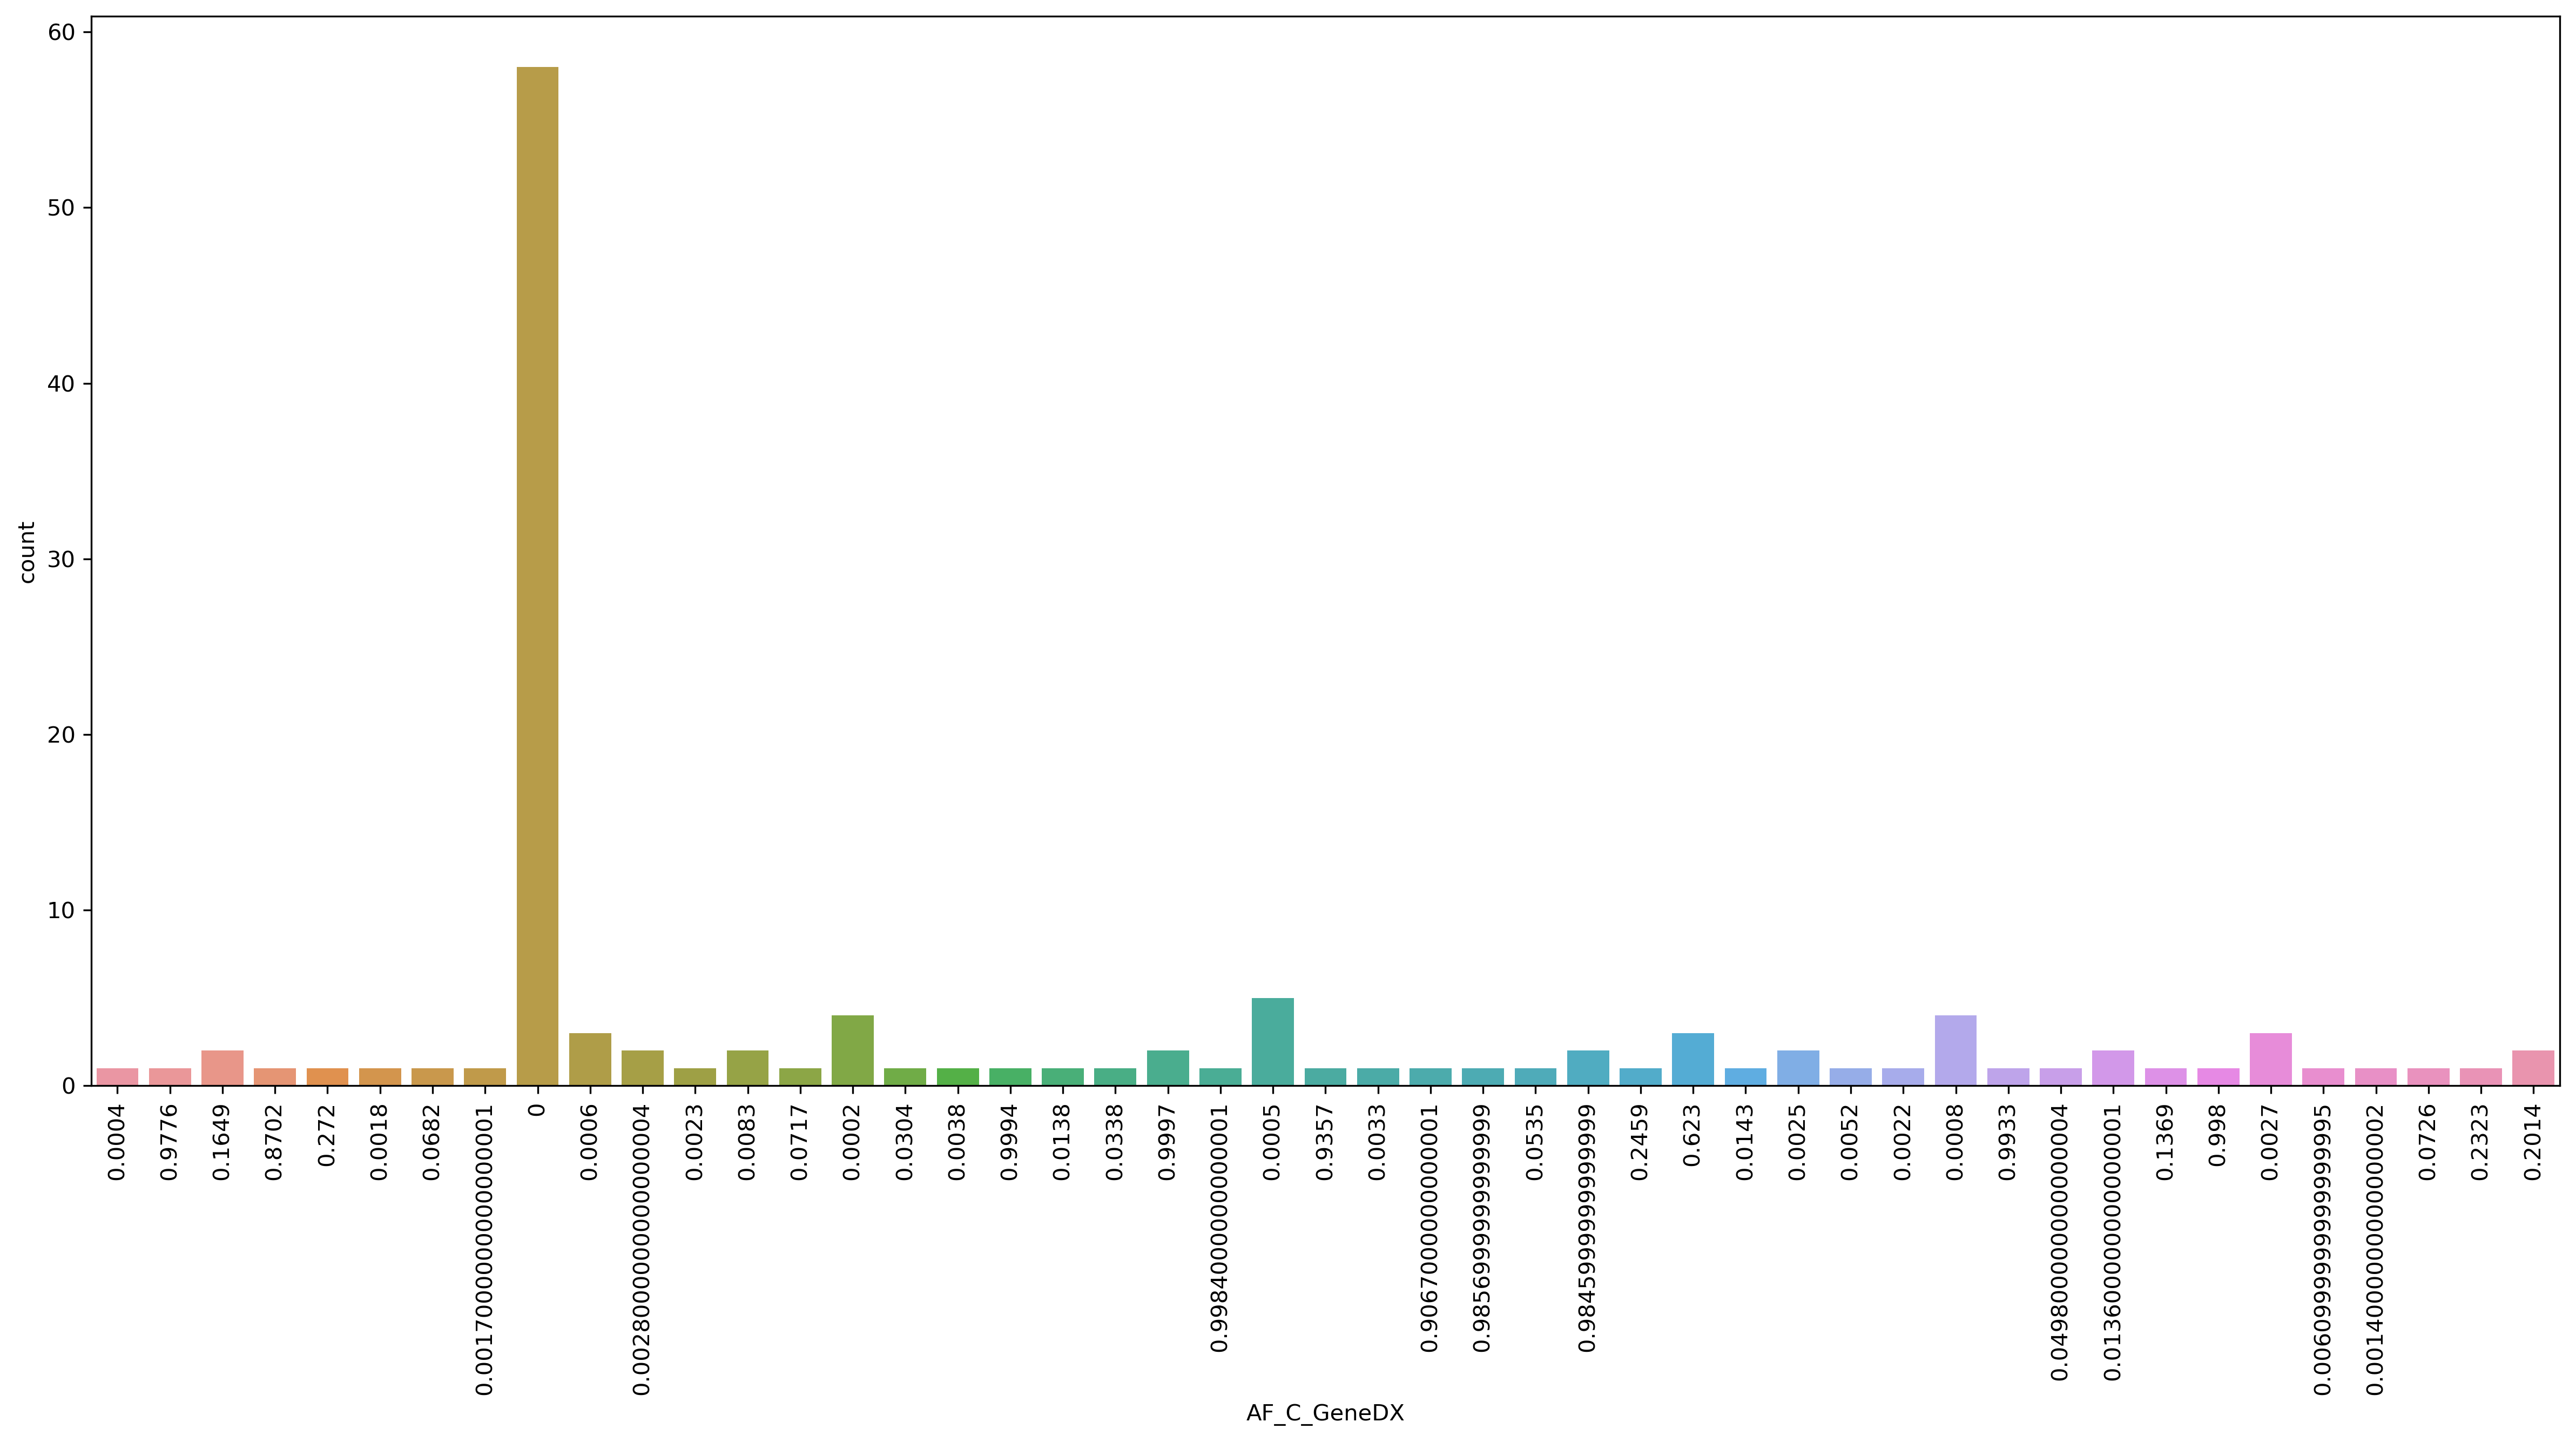

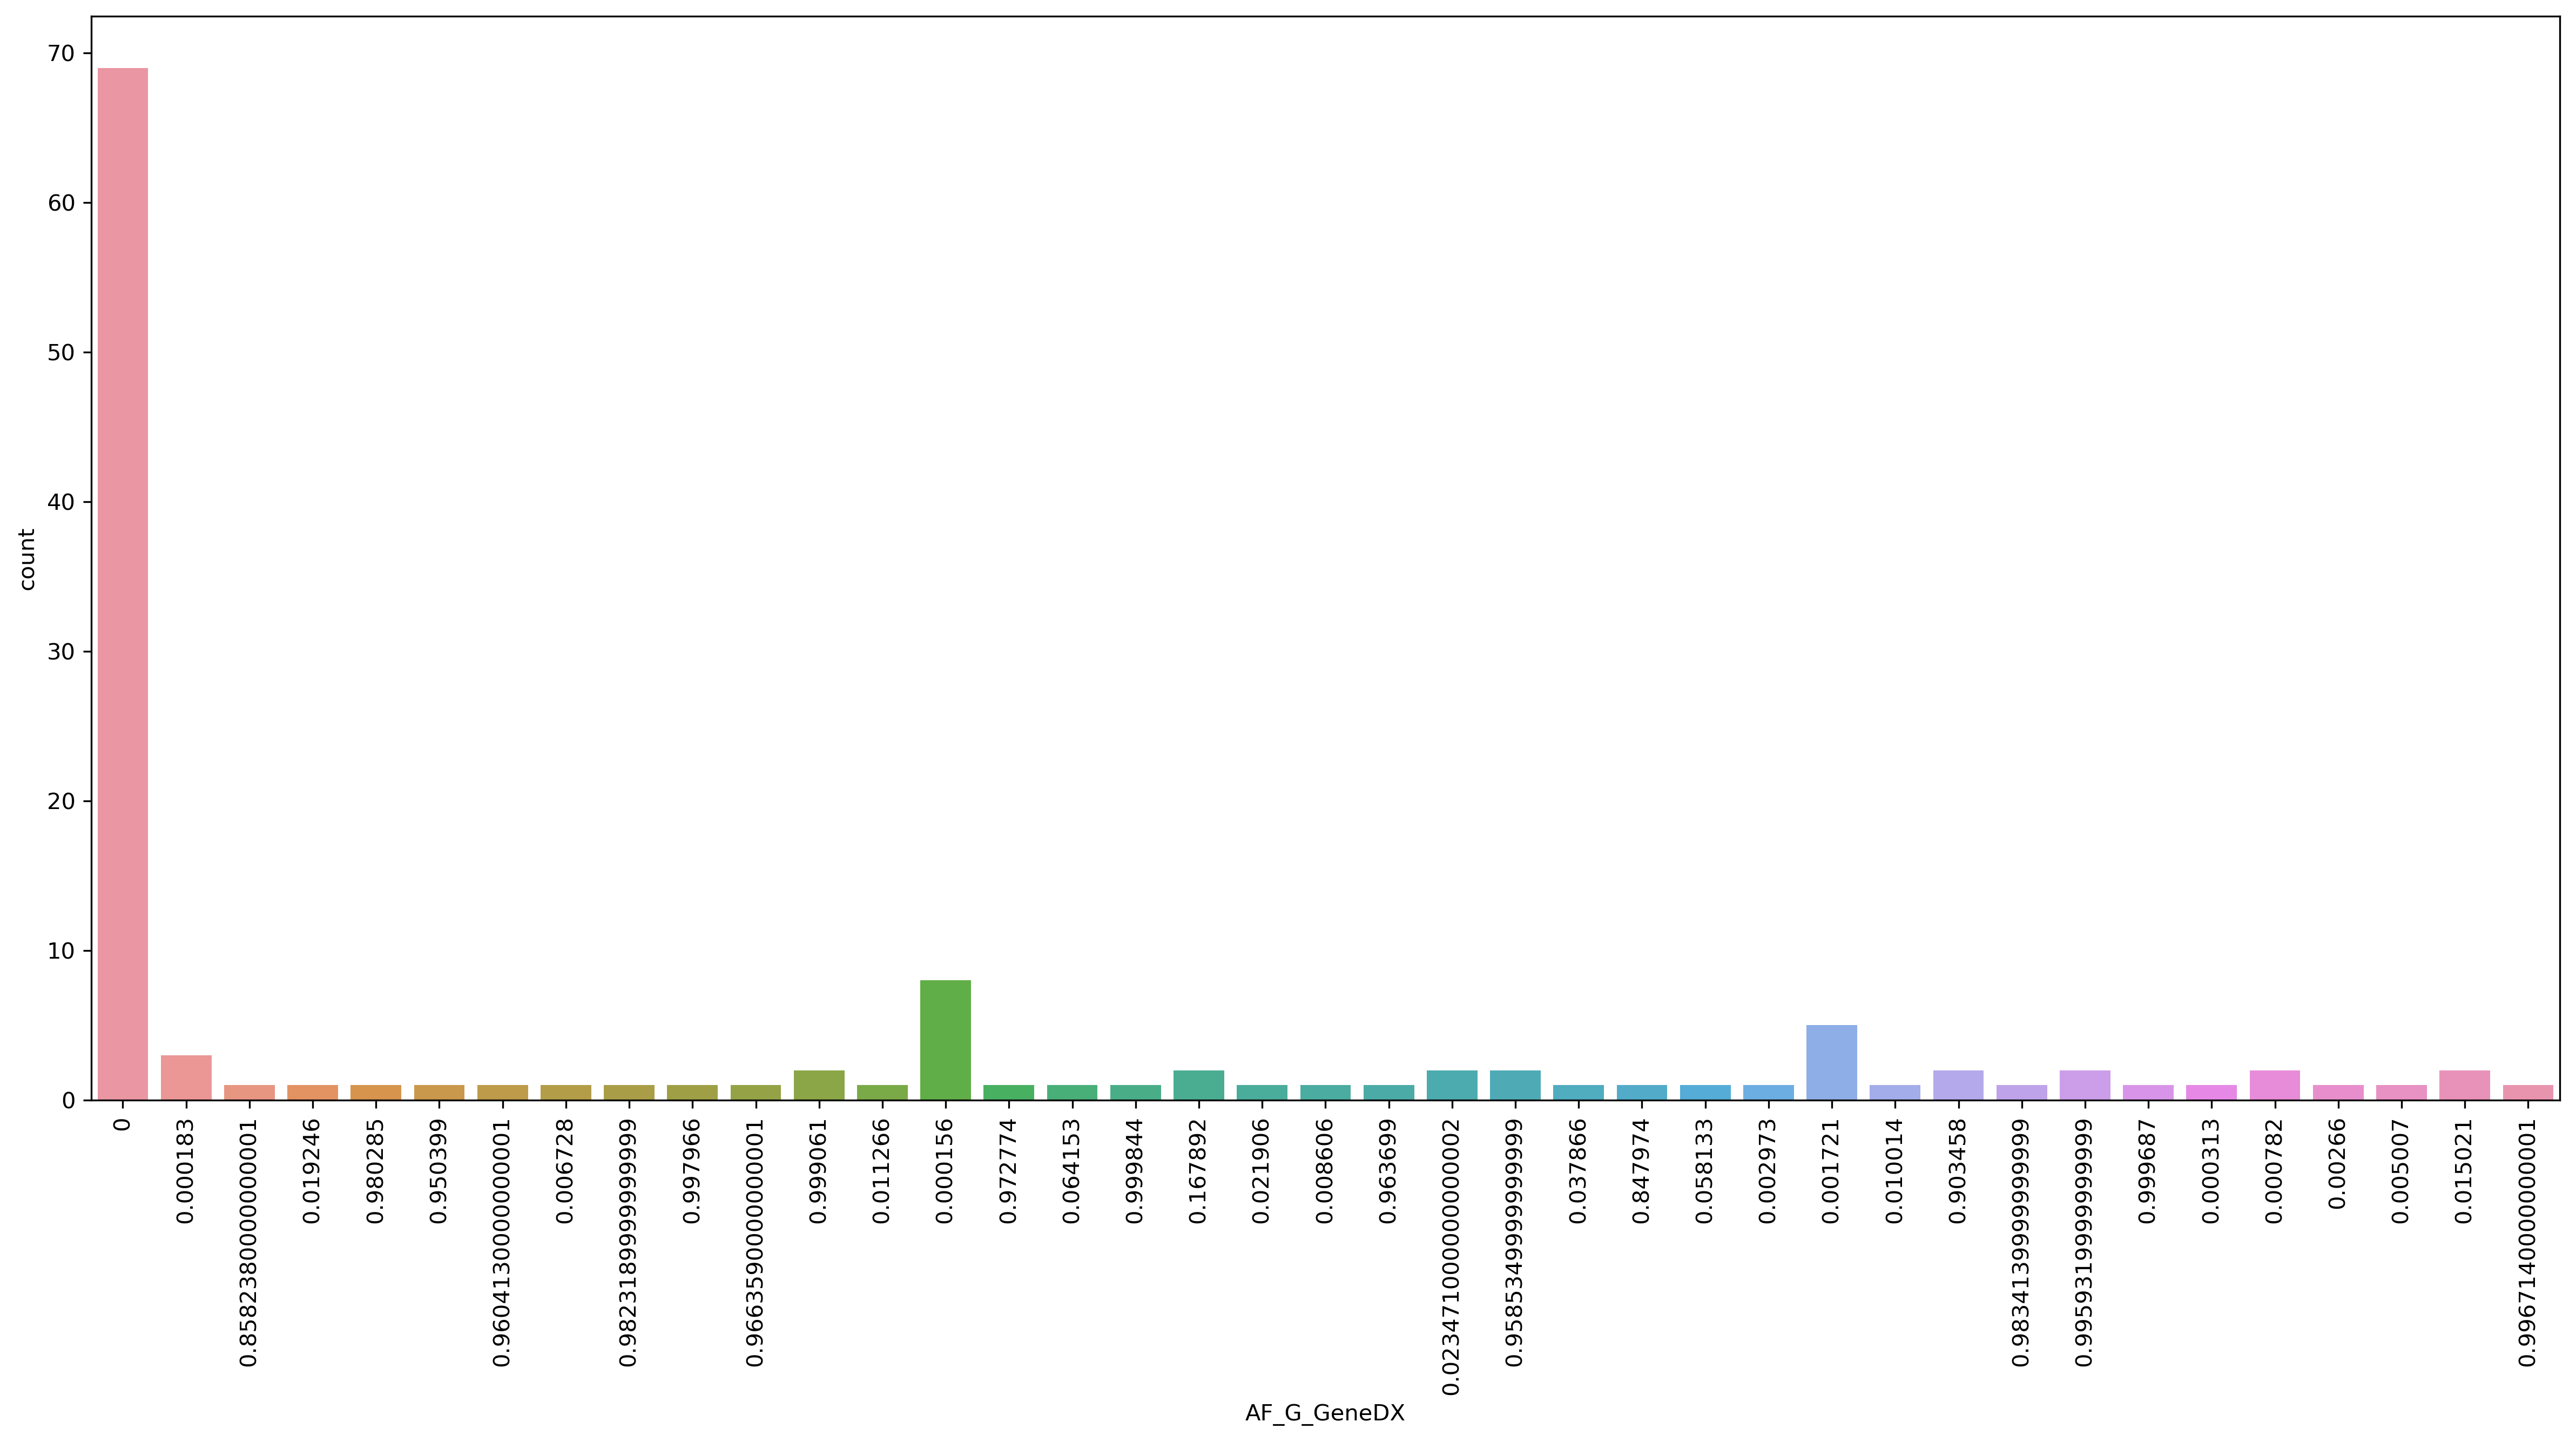

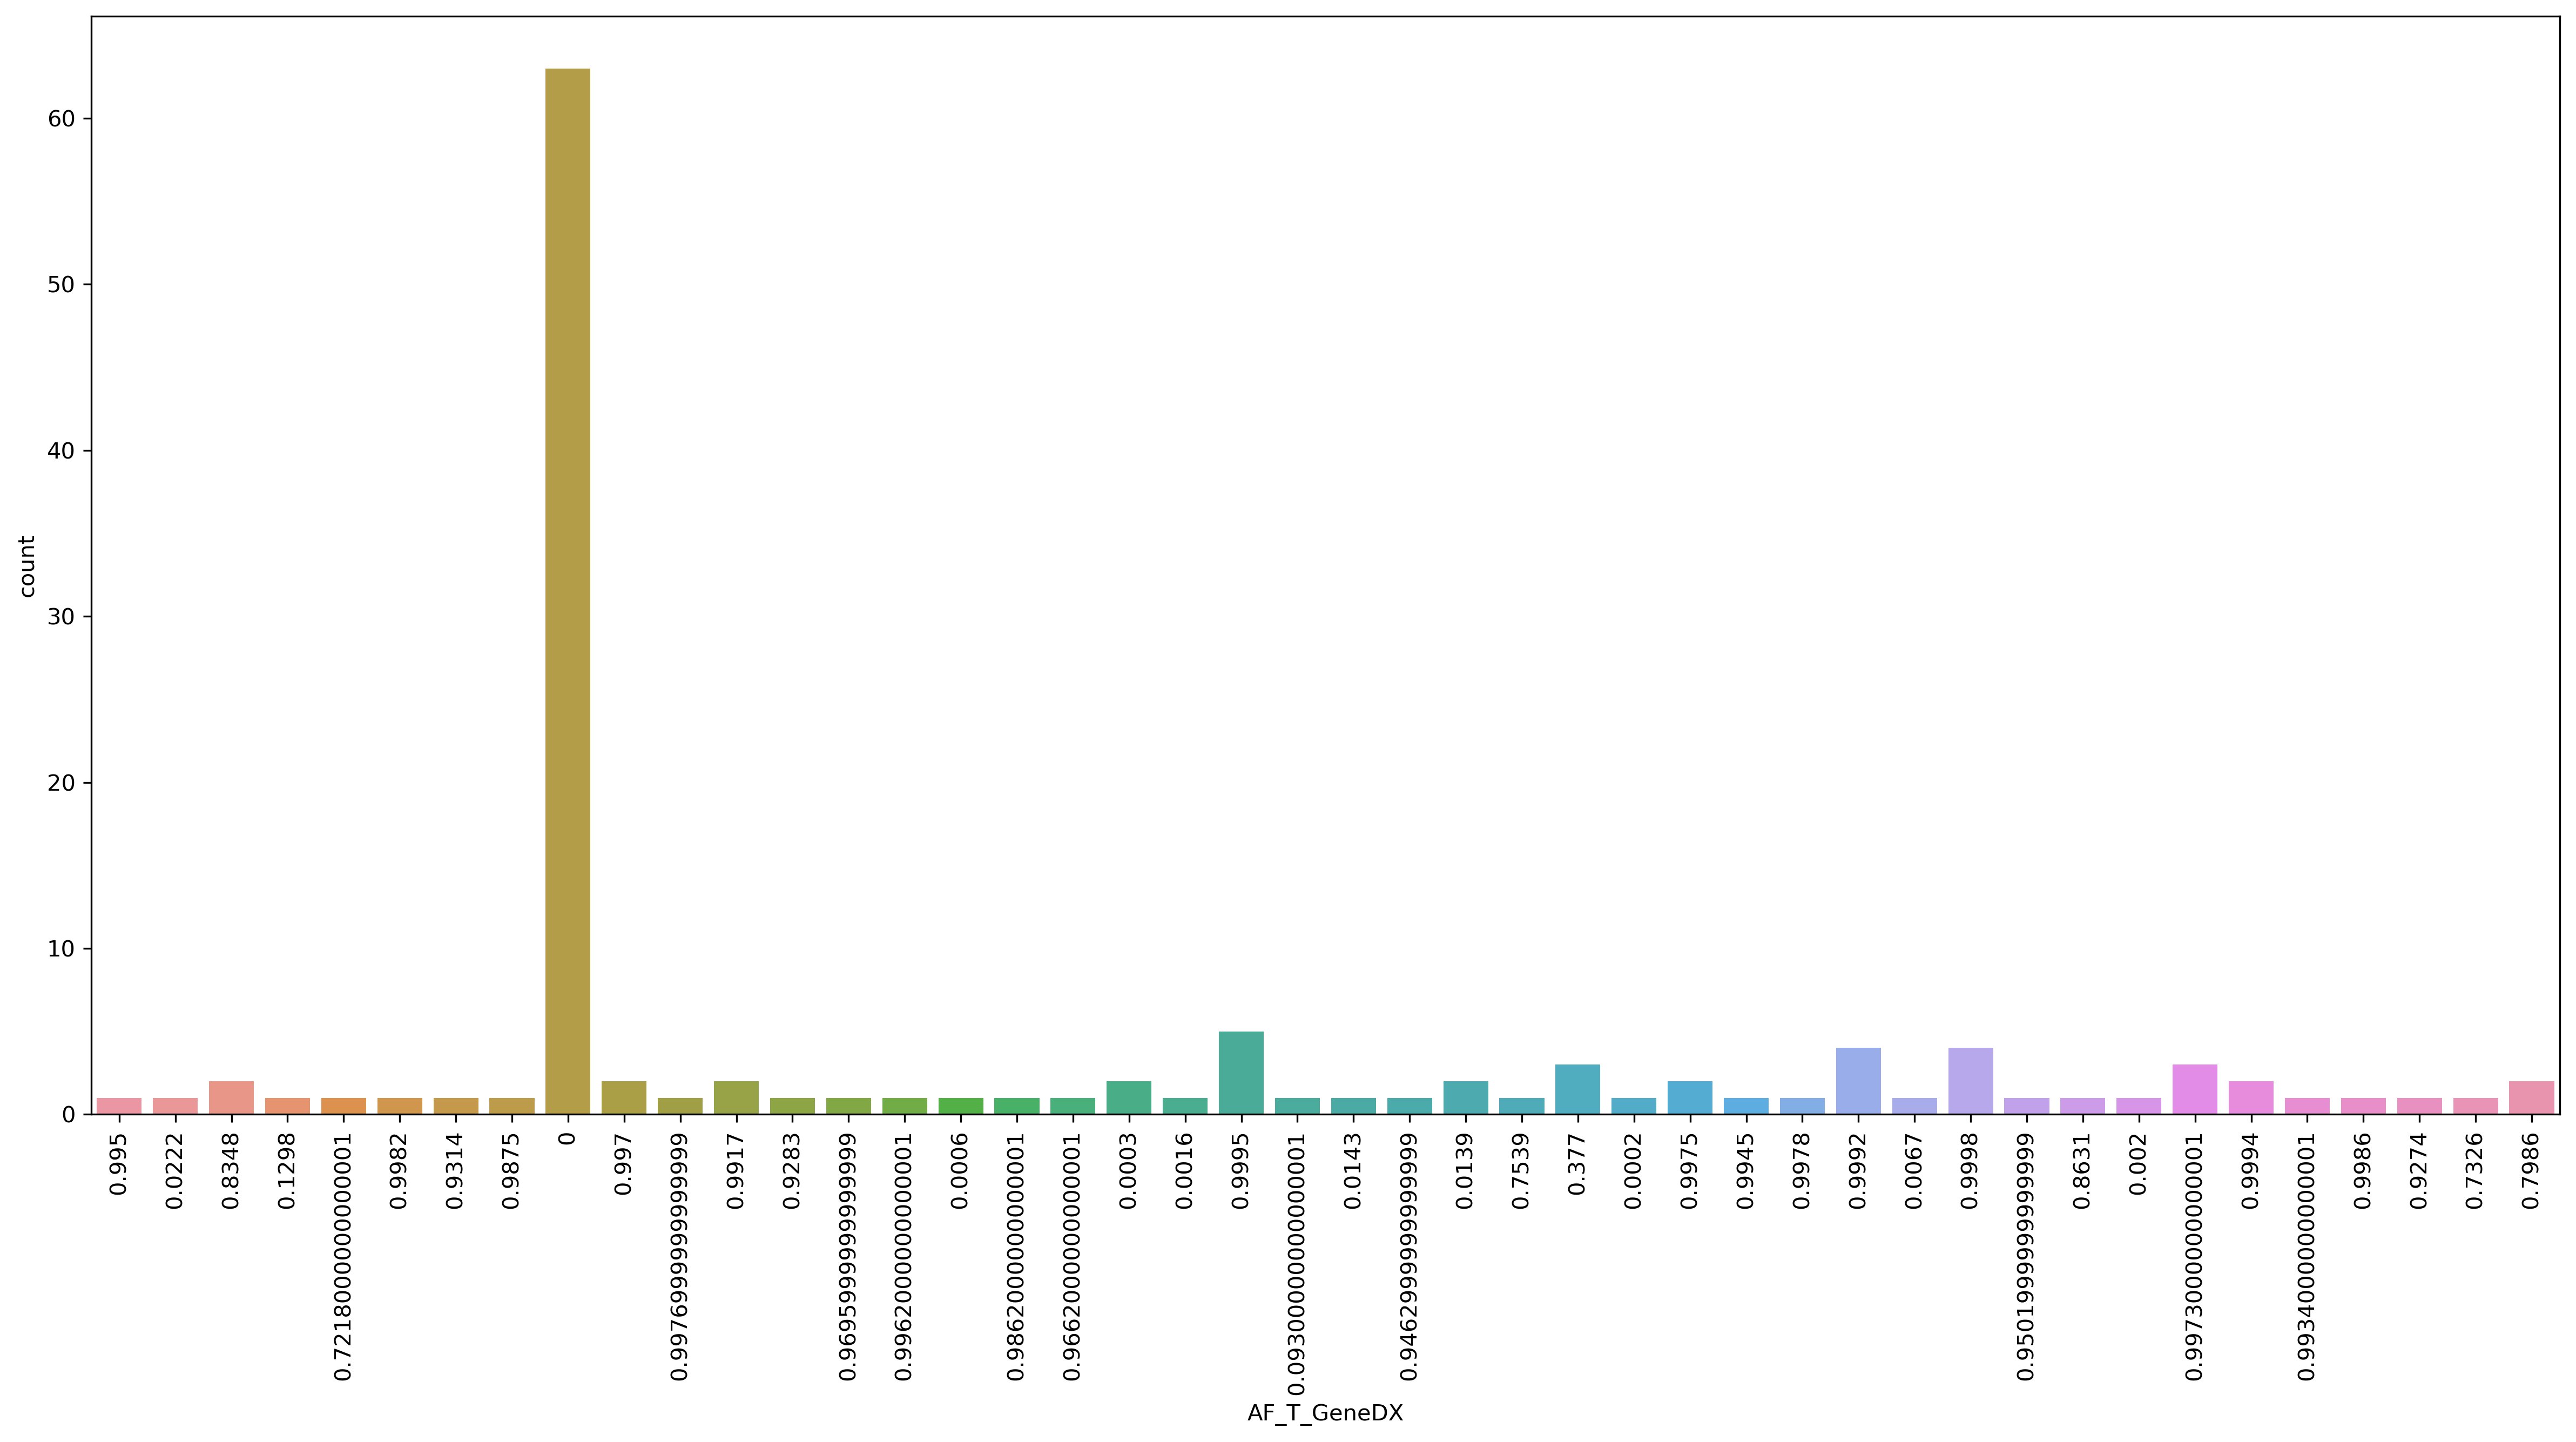

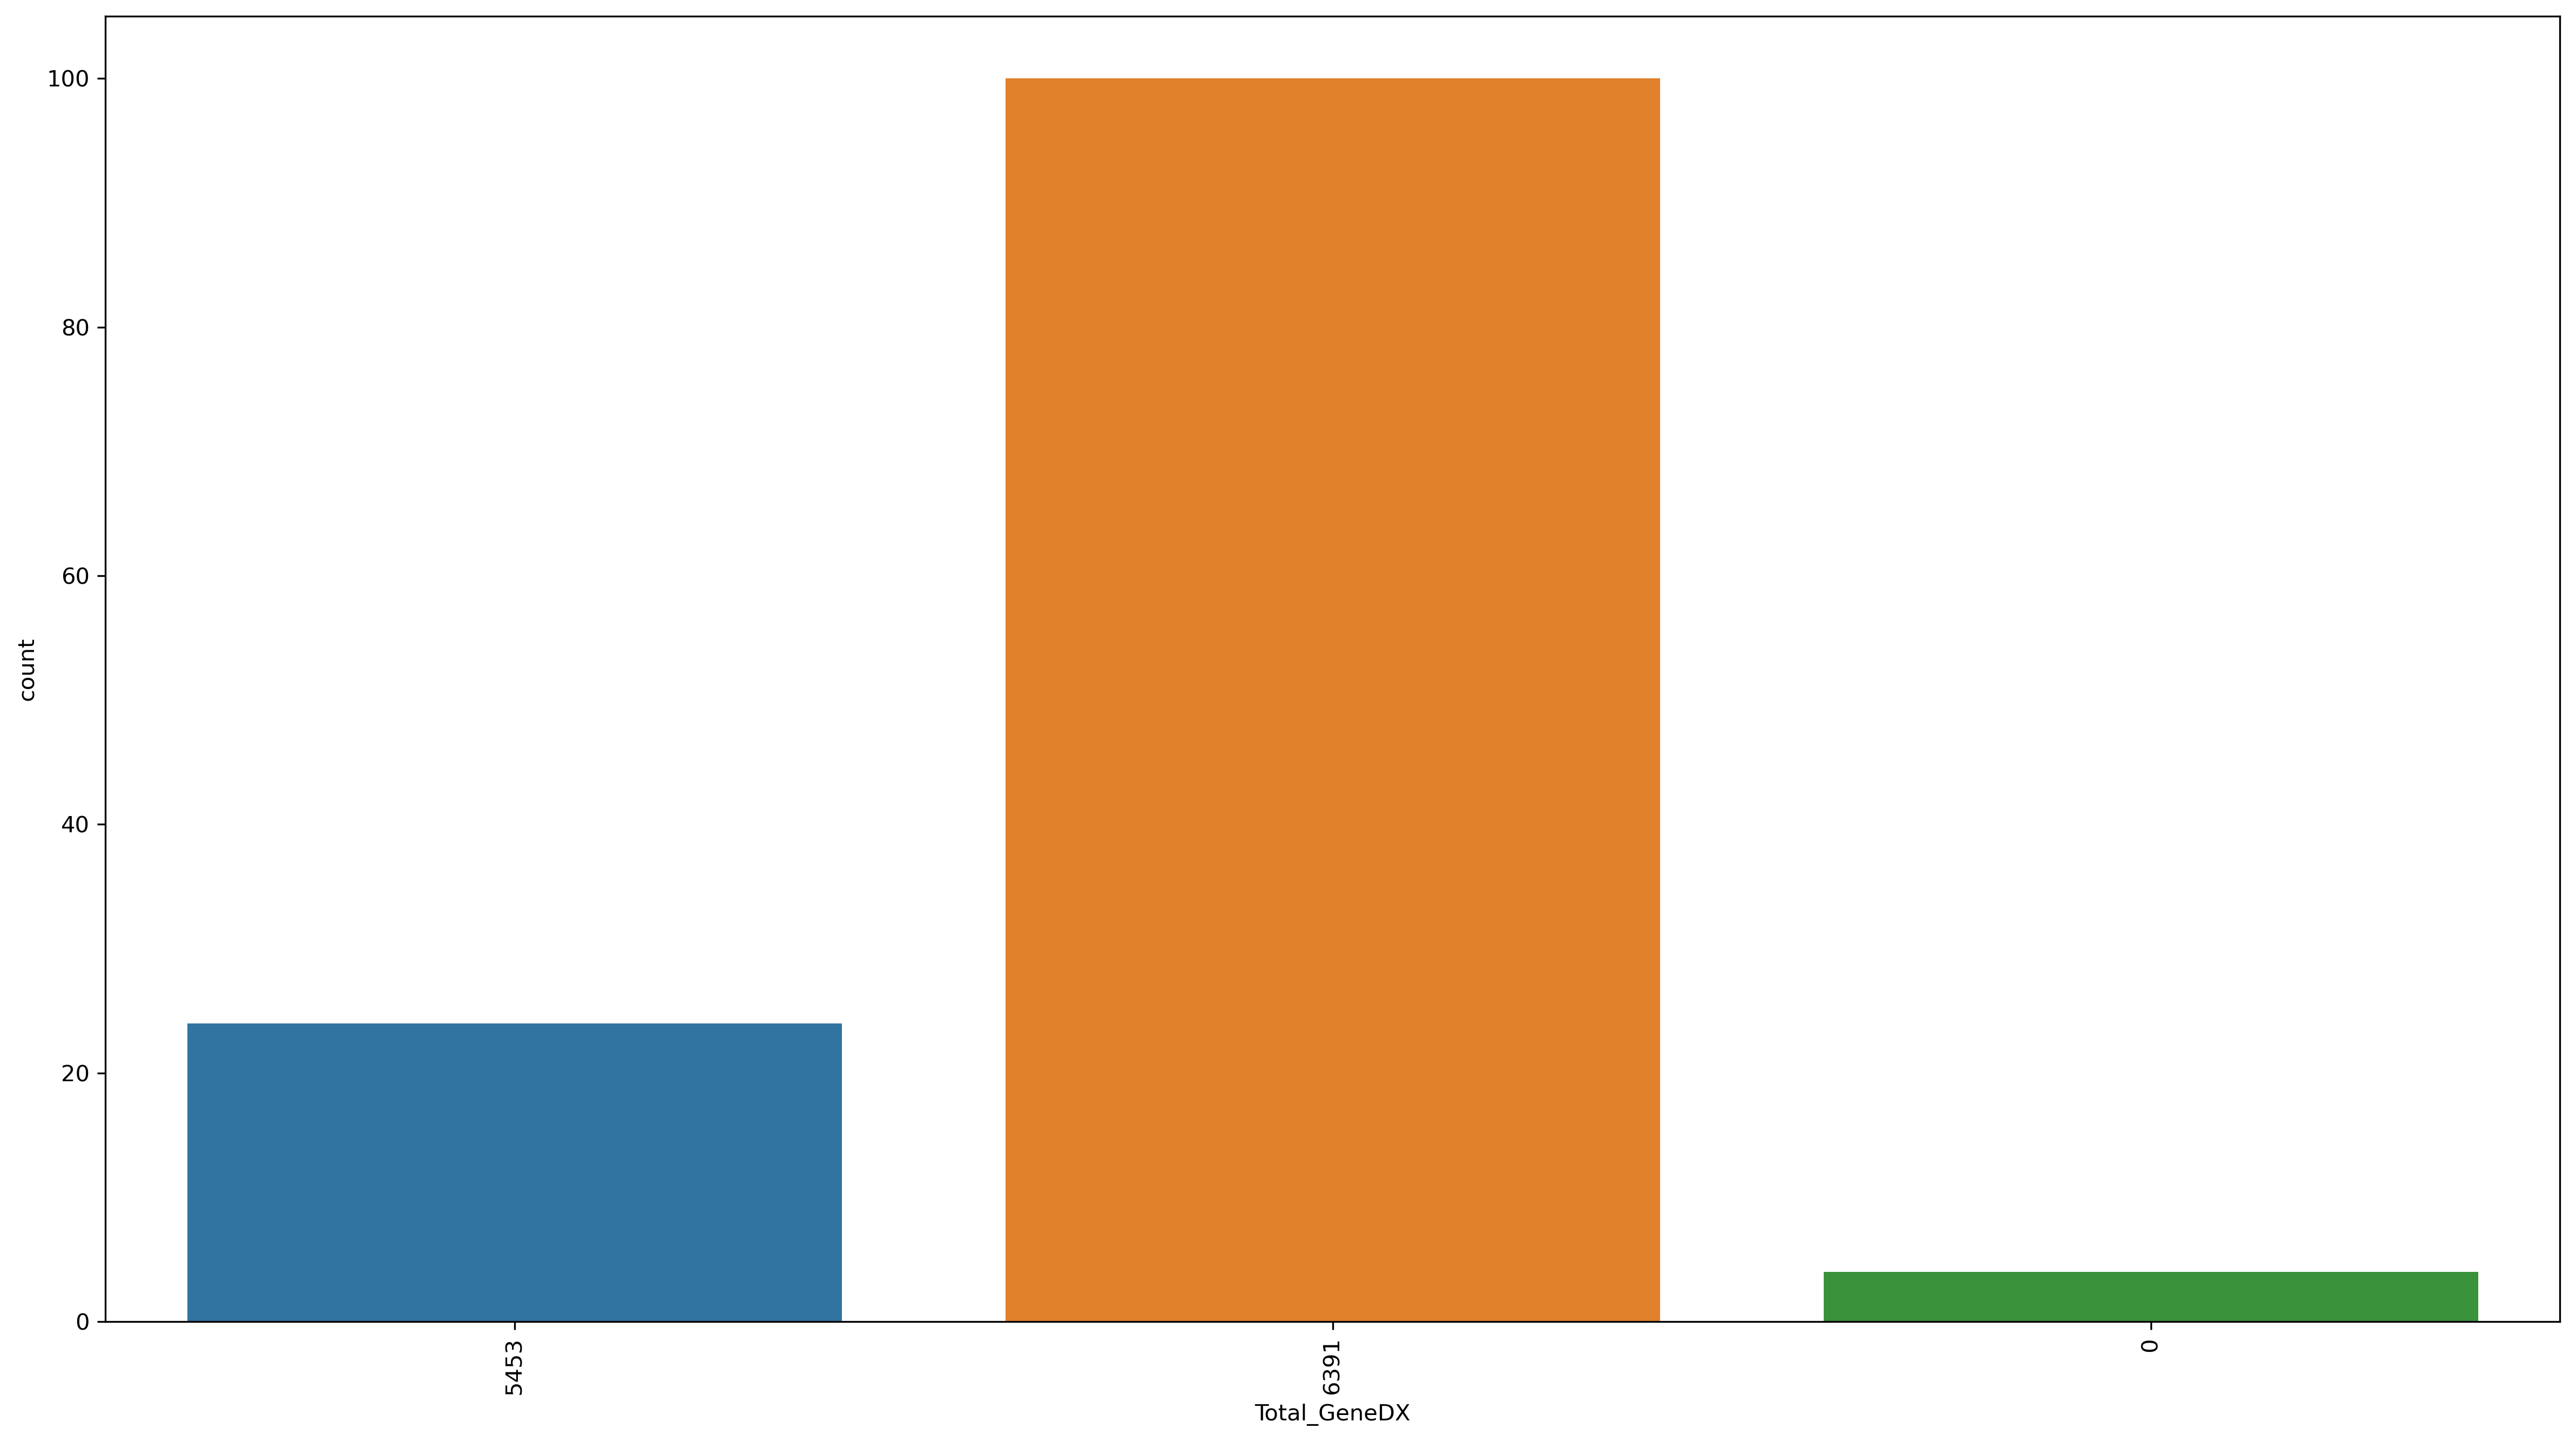

In [20]:
%matplotlib inline
#f, ax = plt.subplots(figsize=(16,16), nrows=len(var_anno_df.columns), squeeze=True)

drop_cols = []
for ind, x in enumerate(var_anno_df.columns.values):
    if not len(var_anno_df[x].dropna().unique())==1:
        f, ax = plt.subplots(figsize=(16,9), dpi=300)
        sns.countplot(data=var_anno_df,x=x)
        #ax[ind].set_xticks(rotation=90)
        #ax[ind].tick_params(axis='x', labelrotation=90 )
        plt.xticks(rotation=90 )
        plt.tight_layout()
        plt.savefig(fig_anno_vars_f.replace('.pdf', f'.{x}.pdf'), bbox_inches='tight', pad_inches=0.5)

    else:
        drop_cols.append(x)


In [ ]:
var_anno_df = var_anno_df.drop(drop_cols, axis=1)
var_anno_df.index = variants.index
pd.concat([variants, var_anno_df],axis=1).to_csv(anno_out_f, sep="\t", index=True)
#var_anno_df.to_csv(anno_out_f, sep="\t", index=True)